In [1]:
import numpy as np
import pickle as pkl
import time
import json
import random
import torch
from torch import nn
import editdistance
import os
import glob
from rnn.loader import make_loader, Preprocessor
from rnn.model import Seq2Seq
from rnn.model import LinearND 
from rnn.model import Attention
import matplotlib.pyplot as plt
np.seterr(divide='ignore') # masks log(0) errors

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
def compute_wer(results):
    """
    Compute the word-error-rate (WER).
    """
    dist = 0.
    for label, pred in results:
        dist += editdistance.eval(label, pred)
    total = sum(len(label) for label, _ in results)
    return dist / total

def train(model, optimizer, ldr):
    """
    Train the model for an epoch (one pass over the training data)
    ----
    model: Seq2Seq model instance
    optimizer: torch.nn optimizer instance
    ldr: data loader instance
    ----
    Returns the average loss over an epoch
    """
    model.train()
    model.scheduled_sampling = model.sample_prob != 0
    
    losses = []
    
    for ii, (inputs, labels) in enumerate(ldr):
        optimizer.zero_grad()
        x, y = model.collate(inputs, labels)
        loss = model.loss(x, y)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.data.item())
        
    return np.nanmean(losses)

def evaluate(model, ldr, preproc, store_prediction=False, print_prediction=False):
    """
    Evaluate the model (on either dev or test).
    ----
    model: Seq2Seq model instance
    ldr: data loader instance
    preproc: preprocessor instance
    ----
    Returns the average loss and wer on a given dataset
    """
    model.eval()
    model.scheduled_sampling = False
    
    losses, hyps, refs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in ldr:
            x, y = model.collate(inputs, labels)
            # get loss
            loss = model.loss(x, y)
            losses.append(loss.data.item())
            # get predictions
            pred = model.infer(x, y)
            hyps.extend(pred)
            refs.extend(labels)

    results = [(preproc.decode(r), preproc.decode(h)) for r, h in zip(refs, hyps)]
    
    if store_prediction:
        with open("test_results.json", "w") as res:
            json.dump(results, res)

    if print_prediction:
        for (truth, pred) in results:
            print('True label:\n  ', end="")
            for char in truth:
                print(char, end=" ")
            print('\nPredicted labal:\n  ', end="")
            for char in pred:
                print(char, end=" ")
            print('')

    return np.nanmean(losses), compute_wer(results)

In [3]:
#Loading

with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

data_cfg = config["data"]
opt_cfg = config["optimizer"]

start = time.time()
preproc = Preprocessor(data_cfg["all_data"], start_and_end=data_cfg["start_and_end"])
print("Preprocessing finished", time.time() - start, "seconds elapsed")

start = time.time()
train_ldr = make_loader(data_cfg["train_set"], preproc, opt_cfg["batch_size"])
print("Train Loaded", time.time() - start, "seconds elapsed")   

start = time.time()    
dev_ldr = make_loader(data_cfg["dev_set"], preproc, opt_cfg["batch_size"])
print("Dev Loaded", time.time() - start, "seconds elapsed")

start = time.time()
test_ldr = make_loader(data_cfg["test_set"], preproc, opt_cfg["batch_size"])
print("Test Loaded", time.time() - start, "seconds elapsed")

Preprocessing finished 21.139957666397095 seconds elapsed
Train Loaded 1855.936060667038 seconds elapsed
Dev Loaded 270.1701924800873 seconds elapsed
Test Loaded 552.4445633888245 seconds elapsed


In [4]:
#Training
# Reload config if changed epoch
with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)
model_cfg = config["model"]
opt_cfg = config["optimizer"]
print("max epochs:", opt_cfg["max_epochs"])

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.deterministic = True

print("Training RNN")
print("------------")

attention = Attention(model_cfg["encoder"]["hidden_size"], model_cfg["decoder"]["hidden_size"], 512)
model = Seq2Seq(preproc.input_dim, preproc.vocab_size, attention, model_cfg)
model = model.cuda() if use_cuda else model.cpu()

optimizer = torch.optim.SGD(model.parameters(), lr=opt_cfg["learning_rate"], momentum=opt_cfg["momentum"])
#change this
mslst = [int(y) for y in [50 * (2 ** x) for x in range(20)] if y < opt_cfg["max_epochs"]]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=mslst, gamma=0.1)

log="epoch {:4} | train_loss={:6.2f}, dev_loss={:6.2f} with {:6.2f}% WER ({:6.2f}s elapsed)"
losses = []
weres = []


best_so_far = float("inf")
for ep in range(opt_cfg["max_epochs"]):
    start = time.time()
    scheduler.step()

    train_loss = train(model, optimizer, train_ldr)    
    dev_loss, dev_wer = evaluate(model, dev_ldr, preproc)    
    losses.append(dev_loss)
    weres.append(dev_wer)
    
    print(log.format(ep + 1, train_loss, dev_loss, dev_wer * 100., time.time() - start))
    for param_group in optimizer.param_groups:
        print('...learning rate: ' + str(param_group['lr']))

    torch.save(model, os.path.join(config["save_path"], str(ep)))   
    if dev_wer < best_so_far:
        best_so_far = dev_wer
        torch.save(model, os.path.join(config["save_path"], "best"))

max epochs: 100
Training RNN
------------
epoch    1 | train_loss=234.66, dev_loss=210.34 with 115.37% WER (206.49s elapsed)
...learning rate: 0.1
epoch    2 | train_loss=223.56, dev_loss=209.09 with  95.00% WER (202.48s elapsed)
...learning rate: 0.1
epoch    3 | train_loss=217.11, dev_loss=190.31 with 398.86% WER (229.97s elapsed)
...learning rate: 0.1
epoch    4 | train_loss=213.29, dev_loss=170.11 with  96.88% WER (204.77s elapsed)
...learning rate: 0.1
epoch    5 | train_loss=208.93, dev_loss=179.47 with 101.18% WER (205.28s elapsed)
...learning rate: 0.1
epoch    6 | train_loss=208.13, dev_loss=159.09 with 577.80% WER (229.24s elapsed)
...learning rate: 0.1
epoch    7 | train_loss=205.34, dev_loss=143.50 with 147.39% WER (224.59s elapsed)
...learning rate: 0.1
epoch    8 | train_loss=202.73, dev_loss=136.41 with  95.26% WER (201.81s elapsed)
...learning rate: 0.1
epoch    9 | train_loss=199.55, dev_loss=136.79 with  95.99% WER (201.92s elapsed)
...learning rate: 0.1
epoch   10 | 

epoch   75 | train_loss=  0.29, dev_loss=  3.79 with  38.62% WER (203.37s elapsed)
...learning rate: 0.010000000000000002
epoch   76 | train_loss=  0.29, dev_loss=  3.76 with  37.92% WER (203.36s elapsed)
...learning rate: 0.010000000000000002
epoch   77 | train_loss=  0.26, dev_loss=  3.72 with  37.46% WER (202.98s elapsed)
...learning rate: 0.010000000000000002
epoch   78 | train_loss=  0.27, dev_loss=  3.71 with  37.70% WER (202.59s elapsed)
...learning rate: 0.010000000000000002
epoch   79 | train_loss=  0.24, dev_loss=  3.68 with  37.51% WER (202.86s elapsed)
...learning rate: 0.010000000000000002
epoch   80 | train_loss=  0.23, dev_loss=  3.66 with  37.54% WER (203.08s elapsed)
...learning rate: 0.010000000000000002
epoch   81 | train_loss=  0.22, dev_loss=  3.65 with  38.20% WER (203.51s elapsed)
...learning rate: 0.010000000000000002
epoch   82 | train_loss=  0.21, dev_loss=  3.63 with  37.67% WER (203.40s elapsed)
...learning rate: 0.010000000000000002
epoch   83 | train_loss=

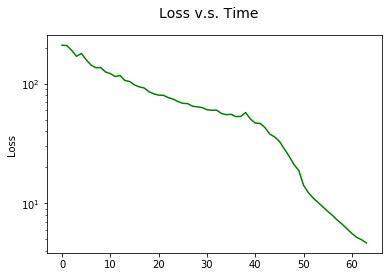

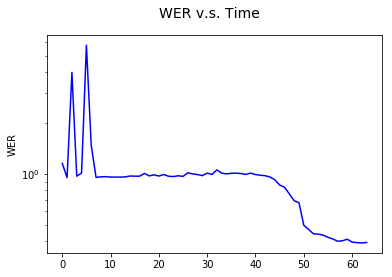

In [5]:
eps = list(range(opt_cfg["max_epochs"]))
'''
fig, ax1 = plt.subplots()
plt.suptitle("Loss & WER v.s. Time", fontsize=14)
ax2 = ax1.twinx()
ax1.plot(eps[:61], losses[:61], 'green')
ax2.plot(eps[:61], weres[:61], 'blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='green')
ax2.set_ylabel('WER', color='blue')
'''
plt.suptitle("Loss v.s. Time", fontsize = 14)
plt.plot(eps[:64], losses[:64], 'green')
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

plt.suptitle("WER v.s. Time", fontsize = 14)
plt.plot(eps[:64], weres[:64], 'blue')
plt.ylabel("WER")
plt.yscale("log")
plt.show()

In [6]:
#Testing

print("Testing RNN")
print("-------------")

test_model = torch.load(os.path.join(config["save_path"], "best"))
_, test_wer = evaluate(test_model, test_ldr, preproc, store_prediction=True, print_prediction=True)

print("{:.2f}% WER (test)".format(test_wer * 100.))

Testing RNN
-------------


D:\TTIC-31110-Final-Project\rnn\model.py:181: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  x, h = self.enc_rnn(x)
D:\TTIC-31110-Final-Project\rnn\model.py:210: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  ox, hx = self.dec_rnn(ix, hx=hx)
D:\TTIC-31110-Final-Project\rnn\model.py:232: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  ox, hx = self.dec_rnn(ix, hx=hx)


True label:
  liu3 zong1 xia4 xian4 nian2 liu4 shi2 sui4 wu3 shi2 nian2 dai4 jin4 ru4 han2 wai4 wu4 bu4 gong1 zuo4 yi1 jiu3 jiu3 si4 nian2 shi2 er4 yue4 ren4 wai4 jiao1 an1 bao3 shou3 xi2 mi4 shu1 
Predicted labal:
  liu4 sheng3 qu1 jun1 wei2 huang2 tu3 gao1 yuan2 qu1 shen1 shan1 qu1 huang1 mo4 qu1 he2 gao1 han2 shan1 qu1 zi4 ran2 tiao2 jian4 e4 lie4 zai1 hai4 pin2 fan2 
True label:
  ta1 qi2 guai4 zi4 ji3 bu4 jin3 wu2 yi1 si1 xu1 qie4 jing4 you2 zhong3 yu3 dui4 shou3 pin1 sha1 jiao4 liang5 yue4 yue4 yu4 shi4 de5 xin1 jing4 
Predicted labal:
  ta1 qi2 guai4 zi4 ji3 bu4 jin3 wu2 yi1 si1 xu1 qie4 jing4 you2 zhong3 yu3 dui4 shou3 pin1 sha1 jiao4 liang5 yue4 yue4 yu4 shi4 de5 xin1 jing4 
True label:
  zhu1 chen2 zai4 yao3 ya2 pin1 bo2 ta1 de5 dui4 you3 wang2 lei3 wang2 pin2 ye3 fen1 bie2 zai4 yu3 ha1 ge2 luo4 wa2 xi1 jia1 li3 ke1 wa2 ku3 zhan4 
Predicted labal:
  zhu1 chen2 zai4 yao3 ya2 pin1 bo2 ta1 de5 dui4 you3 wang2 lei3 wang2 pin2 ye3 fen1 bie2 zai4 yu3 ha1 ge2 luo4 wa2 xi1 jia1 li3 k

  ta1 men5 cong2 an4 bian1 pa2 qi3 lai5 hun2 shen1 shui3 lin2 lin2 de5 wang3 xia4 you2 pao3 you4 pu1 dao4 xia4 you2 gang1 qi3 de5 bo1 lang4 shang4 
True label:
  xin1 hua2 she4 ji1 duo1 er4 yue4 liu4 ri4 dian4 zui4 jin4 er4 shi2 tian1 lai2 e4 gua1 duo1 er3 quan2 guo2 nve4 ji5 xun4 su4 man4 yan2 yi2 you3 duo1 ren2 si3 wang2 
Predicted labal:
  xin1 hua2 she4 ji1 duo1 er4 yue4 liu4 ri4 dian4 zui4 jin4 er4 shi2 tian1 lai2 e4 gua1 duo1 er3 quan2 guo2 nve4 ji5 xun4 su4 man4 yan2 yi2 you3 duo1 ren2 si3 wang2 
True label:
  yu3 wang2 wei3 si4 ping2 shi4 huo4 che1 si1 ji1 du4 da4 ping2 yue4 yu4 jie2 zhuang1 xie4 gong1 liu2 chun1 shan1 yi4 tong2 zhui1 gan3 tao2 pao3 de5 an4 fan4 
Predicted labal:
  yun4 mu4 zhai4 min2 su2 feng1 qing2 bie2 ju4 yi4 ge2 kai1 zhai4 men2 hun1 qu3 da3 san1 chao2 deng3 shi2 fen1 re4 nao5 ku1 jia4 tiao4 sang1 ji4 re4 nao5 you4 qi2 te4 
True label:
  ta1 shi4 li4 yong4 guang1 bo1 sao3 miao2 pei4 he2 ji1 guang1 guo4 lv4 yi3 hua4 xue2 wu4 xi1 qu4 zao4 mo2 zui4 hou4 yi3 yi

  xian2 yi2 fan4 yan3 kan4 tuo1 tao2 wu2 wang4 cuan4 shang4 wu1 ding3 zong4 shen1 tiao4 xia4 yi4 yu4 zi4 sha1 jie2 guo3 shuai1 cheng2 gu3 zhe2 bei4 sheng1 qin2 
True label:
  suo2 yi3 zhe4 ye3 shou4 you3 shi2 hou4 you4 te4 bie2 de5 yan4 wu4 cu1 su2 chen2 mo4 gua3 yan2 leng3 ku4 de5 ning2 wang4 zhe5 ren2 jian1 
Predicted labal:
  suo2 yi3 zhe4 ye3 shou4 you3 shi2 hou4 you4 te4 bie2 de5 yan4 wu4 cu1 su2 chen2 mo4 gua3 yan2 leng3 ku4 de5 ning2 wang4 zhe5 ren2 jian1 
True label:
  qu4 nian2 si4 yue4 zhong1 xun2 wo3 zhen4 shui4 wu4 suo3 cha2 huo4 yan2 cheng2 shi4 jiao1 qu1 mou3 ge4 ti3 shang1 fan4 zai4 wo3 zhen4 cong2 shi4 shi2 mian2 wa3 jing1 ying2 ye4 wu4 
Predicted labal:
  qu4 nian2 si4 yue4 zhong1 xun2 wo3 zhen4 shui4 wu4 suo3 cha2 huo4 yan2 cheng2 shi4 jiao1 qu1 mou3 ge4 ti3 shang1 fan4 zai4 wo3 zhen4 cong2 shi4 shi2 mian2 wa3 jing1 ying2 ye4 wu4 
True label:
  zhong1 guo2 yao1 qiu2 zai4 bie2 guo2 yi2 qi4 hua4 xue2 wu3 qi4 de5 guo2 jia1 ying1 an4 gong1 yue1 gui1 ding4 jin4 kuai4 che4 

  zai4 shi4 chang3 pi2 ruan3 de5 qing2 kuang4 xia4 zhe4 ge5 cheng2 ji4 lai2 zhi1 bu2 yi4 a5 shuo1 qi3 lai2 yu3 gai1 chang3 chi4 hei1 yue1 ri4 chang2 zhang3 de5 da4 peng2 che1 you3 guan1 
Predicted labal:
  zai4 shi4 chang3 pi2 ruan3 de5 qing2 kuang4 xia4 zhe4 ge5 cheng2 ji4 lai2 zhi1 bu2 yi4 a5 shuo1 qi3 lai2 yu3 gai1 chang3 chi4 hei1 yue1 ri4 chang2 zhang3 de5 da4 peng2 che1 you3 guan1 
True label:
  wei4 xi1 yin3 you2 yong3 ai4 hao4 zhe3 ta1 men5 fa1 shou4 nian2 ka3 yue4 ka3 qing2 lv2 ka3 he2 jia1 huan1 ka3 jin1 ka3 
Predicted labal:
  wei4 xi1 yin3 you2 yong3 ai4 hao4 zhe3 ta1 men5 fa1 shou4 nian2 ka3 yue4 ka3 qing2 lv2 ka3 he2 jia1 huan1 ka3 jin1 ka3 
True label:
  zai4 yue4 qian2 shan1 bi3 xia4 gui4 zhou1 shan1 chuan1 feng1 wu4 yun4 cang2 zhe5 nong2 lie4 de5 nuo2 xi4 yi4 wei4 chong1 yi4 zhe5 zhi4 pu3 ye3 yi4 de5 qi4 xi1 
Predicted labal:
  zai4 yue4 qian2 shan1 bi3 xia4 gui4 zhou1 shan1 chuan1 feng1 wu4 yun4 cang2 zhe5 nong2 lie4 de5 nuo2 xi4 yi4 wei4 chong1 yi4 zhe5 zhi4 pu3 ye3 

  shi1 sheng1 lia2 ji3 shi2 nian2 lai2 yi4 zhi2 wang3 lai2 pin2 fan2 gong4 tong2 tan4 tao3 yi4 xie1 ju2 wai4 ren2 ting1 lai2 you3 xie1 xuan2 ao4 de5 li3 xue2 
Predicted labal:
  shi4 ji3 ge4 yue4 zhi2 lai2 yuan2 mu4 pin2 yi4 zhi2 pin2 fan2 gong4 sheng1 zhi2 gong1 ye4 yuan2 tan4 tao3 xie1 ju2 wai4 ren2 ting1 lai2 you3 xie1 xuan2 ao4 de5 li3 xue2 
True label:
  chu2 guo2 jia1 gui1 ding4 zhuan1 yong4 she4 shi1 de5 zhuan1 yong4 yan2 se4 wai4 fan2 bu4 fu3 he2 ben3 tong1 gao4 gui1 ding4 yong4 se4 de5 yao4 yu2 yi3 gai3 zheng4 
Predicted labal:
  zhu4 guo2 jia1 guan1 zhuan1 jia1 de5 hua4 yu3 wai4 guo2 xuan2 shou3 zu3 dui4 can1 jia1 shuang1 da3 yu4 xuan3 sai4 wai4 jun1 jiang1 zhi2 jie1 jin4 ru4 zheng4 sai4 
True label:
  ji2 bai3 kuai4 ni2 yan4 zhuang1 jin4 tu3 yao2 shao1 le5 qi1 tian1 bu2 liao4 yi4 sheng1 zha4 lei2 yao2 beng1 le5 jing1 de5 yuan4 zi5 li3 ji1 fei1 gou3 tiao4 zhu1 pao3 quan1 
Predicted labal:
  ji2 bai3 kuai4 ni2 yan4 zhuang1 jin4 tu3 yao2 shao1 le5 qi1 tian1 bu2 liao4 yi4 sheng1

  na4 shi2 wo3 yi3 jing1 shang4 xue2 bang4 wan3 fang4 xue2 hou4 ting1 shuo1 lin2 cun1 you3 xi4 cao2 cao3 ba1 ji3 kou3 fan4 xin1 bian4 bei4 lin2 cun1 de5 luo2 gu3 sheng1 yin3 le5 qu4 
Predicted labal:
  ba1 qi2 da4 xue2 zhi1 yuan2 hua2 di3 da4 xue2 zhi1 bing1 you3 de5 wei4 ta1 de5 zhi4 shao3 zai4 wu3 yi4 nian2 shi2 wu3 yi4 nian2 de5 jing1 song4 wang3 de5 li3 dan4 yi2 qie4 
True label:
  feng1 ping2 lang4 jing4 de5 qi1 hei1 wu3 ye4 wang2 yun2 zhou1 wang2 xin1 huai2 wang2 yang2 zi5 shou3 xian1 fa1 xian4 guai4 wu5 shan3 zhe5 hong2 guang1 de5 yan3 jing5 
Predicted labal:
  feng1 xian4 shi4 zheng4 de5 qi1 hei1 wu3 ye4 qing1 ye4 yang3 di1 wen1 gao1 neng2 tui1 jin4 ji4 bing4 jie3 jue2 le5 di1 wen1 ji4 shu4 de5 ying4 yong4 wen4 ti2 
True label:
  bei3 jing1 fu4 wai4 yi1 yuan4 xin1 wai4 ke1 zhuan1 jia1 han2 xu4 de5 jie3 shi5 biao3 ming2 huan4 er2 mu3 qin1 ti3 zhi4 ji2 cha4 zhi2 jie1 ying2 xiang3 le5 hou4 dai4 de5 jian4 kang1 
Predicted labal:
  bei3 jing1 fu4 wai4 yi1 yuan4 xin1 wai4 ke1 zhuan1 

  ru2 guo3 chao1 guo4 cheng2 ben3 mu4 biao1 yi2 gai4 fou3 jue2 yao4 me5 gan4 yao4 me5 rang4 wei4 yao4 me5 shou4 jiang3 yao4 me5 ai2 fa2 
True label:
  guo2 wai4 you3 guan1 zhuan1 jia1 diao4 cha2 le5 san1 bai3 duo1 ming2 chang2 shou4 zhe3 ren4 wei2 qin2 yu2 yong4 nao3 ke3 yan2 huan3 shuai1 lao3 er2 lan3 duo4 ke3 shi3 ren2 zao3 shuai1 
Predicted labal:
  guo2 nei4 you3 guan1 zhuan1 jia1 de5 yan2 jiu1 ye3 biao3 ming2 jin4 qi1 wo3 guo2 xin4 yong4 ka3 de5 ying4 yong4 zhi4 shao3 zai4 wu3 da4 ling3 yu4 you3 zhe5 you4 ren2 de5 qian2 jing3 
True label:
  na4 shi2 wo3 yi3 jing1 shang4 xue2 bang4 wan3 fang4 xue2 hou4 ting1 shuo1 lin2 cun1 you3 xi4 cao2 cao3 ba1 ji3 kou3 fan4 xin1 bian4 bei4 lin2 cun1 de5 luo2 gu3 sheng1 yin3 le5 qu4 
Predicted labal:
  na4 sha1 zhi1 ye4 ta1 wang4 zhe5 yue4 se4 xia4 de5 bo1 tao1 dian4 ji4 zhe5 qian1 li3 zhi1 yao2 de5 jiang1 huai2 zai1 min2 che4 ye4 wei4 mian2 
True label:
  feng1 ping2 lang4 jing4 de5 qi1 hei1 wu3 ye4 wang2 yun2 zhou1 wang2 xin1 huai2 wang2 yang2 

  kai1 hui4 de5 hui4 chang3 gu1 ji4 zhi2 you3 er4 shi2 er4 she4 shi4 du4 er2 wu3 hou4 shi4 wai4 de5 zui4 gao1 qi4 wen1 chang2 da2 san1 shi5 san1 she4 shi4 du4 zuo3 you4 
Predicted labal:
  kai1 hui4 de5 hui4 chang3 gu1 ji4 zhi2 you3 er4 shi2 er4 she4 shi4 du4 er2 wu3 hou4 shi4 wai4 de5 zui4 gao1 qi4 wen1 chang2 da2 san1 shi5 san1 she4 shi4 du4 zuo3 you4 
True label:
  san1 shi4 yao4 xia4 jue2 xin1 dui4 yu4 suan4 wai4 zi1 jin1 jin4 xing2 qing1 li3 zheng3 dun4 ba3 ying1 na4 ru4 yu4 suan4 de5 yu4 suan4 wai4 zi1 jin1 dou1 na4 ru4 yu4 suan4 guan2 li3 
Predicted labal:
  san1 shi4 yao4 xia4 jue2 xin1 dui4 yu4 suan4 wai4 zi1 jin1 jin4 xing2 qing1 li3 zheng3 dun4 ba3 ying1 na4 ru4 yu4 suan4 de5 yu4 suan4 wai4 zi1 jin1 dou1 na4 ru4 yu4 suan4 guan2 li3 
True label:
  wo3 ba3 ning2 er2 tuo1 gei3 han2 sao3 dai4 zhe5 bin1 wa2 shang4 lai5 de5 you4 pa4 na4 xie1 hei1 xin1 gan1 xiao3 de5 bu4 gan3 dai4 lai2 gei3 ni3 kan4 
Predicted labal:
  wo3 men5 yin1 wei4 xin4 fo2 er2 nian4 fo2 yin1 wei4 nian4 fo2 e

  ta1 ju4 you3 bao3 liu2 ya2 gen1 jian3 chu2 ba2 ya2 tong4 ku3 jia1 qiang2 ya2 gen1 gong1 neng2 yi3 ji2 shi3 yi4 chi3 wen3 ding4 bu2 yi4 tuo1 wei4 deng3 you1 dian3 
Predicted labal:
  ta1 ju4 you3 bao3 liu2 ya2 gen1 jian3 chu2 ba2 ya2 tong4 ku3 jia1 qiang2 ya2 gen1 gong1 neng2 yi3 ji2 shi3 yi4 chi3 wen3 ding4 bu2 yi4 tuo1 wei4 deng3 you1 dian3 
True label:
  si1 ba1 da2 dui4 jiang1 yu2 ming2 wan3 zai4 guang3 zhou1 tian1 he2 ti3 yu4 chang3 yu3 guang3 zhou1 bai2 yun2 yao1 qing3 dui4 zheng1 duo2 guang3 zhou1 wan4 bao3 lu4 he4 sui4 yao1 qing3 sai4 gui4 guan1 
Predicted labal:
  si1 ba1 da2 dui4 jiang1 yu2 ming2 wan3 zai4 guang3 zhou1 tian1 he2 ti3 yu4 chang3 yu3 guang3 zhou1 bai2 yun2 yao1 qing3 dui4 zheng1 duo2 guang3 zhou1 wan4 bao3 lu4 he4 sui4 yao1 qing3 sai4 gui4 guan1 
True label:
  chang2 an1 huan4 shang4 le5 lan2 ai4 guo2 bu4 de5 xiao4 fu2 bu2 shang4 ban4 nian2 lian3 se4 ye3 hong2 run4 le5 ge1 bo5 tui3 wan4 ye3 cu1 le5 yi1 quan1 
Predicted labal:
  chang2 an1 huan4 shang4 le5 lan2 

  qin2 hua2 da4 xue2 zhi1 yuan2 peng2 huan2 wu3 jin1 jian4 zhong1 deng3 zhe4 jiang1 da4 xue2 zhi1 yuan2 wang2 gan4 chang1 xin1 xian2 jie2 deng3 lai2 suo3 can1 jia1 jian4 suo3 gong1 zuo4 
True label:
  dan4 lie4 ning2 bing4 mei2 you3 yin1 ci3 er2 fou3 ding4 tuo1 er3 si1 tai4 fan3 er2 cheng1 zan4 ta1 de5 zuo4 pin3 shi4 e2 guo2 ge2 ming4 de5 yi2 mian4 jing4 zi5 
Predicted labal:
  zai4 ta1 men5 cong2 yi4 jia1 dao4 le5 ai4 chi1 yi4 wan3 shang5 le5 bing4 you3 li3 zi4 ai4 ta1 yi4 bing4 mei2 you3 ai4 di2 gu5 yi2 zhen4 chang2 zhang3 jue2 ding4 gei3 you1 hui4 jia4 
True label:
  jie3 mei4 lia3 xing4 ge2 tian2 jing4 jie3 jie5 bi3 jiao4 nei4 xiang4 mei4 mei5 ze2 wai4 xiang4 yi4 dian3 er5 dan4 liang3 ren2 dou1 sheng1 xing4 ai4 shui3 yi2 jian4 shui3 jiu4 wan2 ming4 
Predicted labal:
  jie3 mei4 lia3 xing4 ge2 tian2 jing4 jie3 jie5 bi3 jiao4 nei4 xiang4 mei4 mei5 ze2 wai4 xiang4 yi4 dian3 er5 dan4 liang3 ren2 dou1 sheng1 xing4 ai4 shui3 yi2 jian4 shui3 jiu4 wan2 ming4 
True label:
  lao3 ren2 shuo1 

  ran2 er2 cang1 man3 dun4 liu2 de5 hua1 sheng1 bing4 mei2 you3 gei3 nong2 min2 dai4 lai2 duo1 shao3 xi3 yue4 shi2 xia4 wo3 xian4 yue1 you3 wu3 wan4 dun1 hua1 sheng1 ji2 dai4 wai4 xiao1 
Predicted labal:
  ran2 er2 cang1 man3 dun4 liu2 de5 hua1 sheng1 bing4 mei2 you3 gei3 nong2 min2 dai4 lai2 duo1 shao3 xi3 yue4 shi2 xia4 wo3 xian4 yue1 you3 wu3 wan4 dun1 hua1 sheng1 ji2 dai4 wai4 xiao1 
True label:
  yi1 jiu3 si4 yi1 nian2 shi2 yi1 yue4 shan3 gan1 ning2 bian1 qu1 gen1 ju4 san1 san1 zhi4 yuan2 ze2 ju3 xing2 can1 yi4 hui4 yi4 yuan2 jing4 xuan3 yi1 wei4 ming2 jiao4 sen1 jian4 de5 xue2 yuan2 bei4 tui1 wei2 hou4 xuan3 ren2 
Predicted labal:
  yi1 jiu3 si4 yi1 nian2 shi2 yi1 yue4 shan3 gan1 ning2 bian1 qu1 gen1 ju4 san1 san1 zhi4 yuan2 ze2 ju3 xing2 can1 yi4 hui4 yi4 yuan2 jing4 xuan3 yi1 wei4 ming2 jiao4 sen1 jian4 de5 xue2 yuan2 bei4 tui1 wei2 hou4 xuan3 ren2 
True label:
  pu2 yang2 shi4 zheng4 jian4 she4 ri4 xin1 yue4 yi4 jie4 ding4 de5 you2 dian4 fu2 wu4 bu2 duan4 bei4 xin1 lou2 qun2 s

  ke3 shi4 mei2 guo4 duo1 jiu3 zhong1 yu2 dang1 shang4 le5 ya2 lun2 zuan4 si1 zuan4 de5 zi4 hao2 xin1 qing2 jiu4 bei4 zhe4 xie1 yang2 she4 bei5 de5 huai4 pi2 qi5 suo3 po4 huai4 
Predicted labal:
  ke3 shi4 tu4 chang3 de5 nong2 min2 si4 yang3 yuan2 gei3 tu4 zi5 wei4 shi2 wei4 yao4 dou1 bei4 tu4 zi5 shun4 shun5 dang1 dang1 jie1 shou4 le5 
True label:
  shu4 qiang2 an4 zhao4 fu4 qin5 suo3 shuo1 tong2 er4 lin2 he2 mou3 yu3 zhang1 shu4 shi4 yan1 cao3 gong1 si1 de5 liu2 mou3 zai4 kun1 ming2 mou3 fan4 dian4 qia4 tan2 yan1 jia4 
Predicted labal:
  shou4 xi1 hu2 wan1 yan2 qu1 zhe2 zhou1 yu3 san4 luo4 shan1 huan2 shui3 bao4 di1 bian1 yi1 zhu1 zi4 yan1 cao3 yong4 qian1 mi3 qing1 yan1 mao4 chu1 chu1 qu4 
True label:
  hu2 lao3 han4 ai4 shu1 ru2 ming4 nong2 xian2 shi2 zong3 ai4 zou3 cun1 chuan4 hu4 shui2 jia1 you3 shu1 bao4 ta1 jiu4 bao3 bei4 yi2 yang4 shou1 ji2 qi3 lai5 
Predicted labal:
  hu2 lao3 han4 ai4 shu1 ru2 ming4 nong2 xian2 shi2 zong3 ai4 zou3 cun1 chuan4 hu4 shui2 jia1 you3 shu1 bao4 ta

  nong2 min2 guo4 pa4 le5 que1 chi1 shao3 chuan1 de5 qiong2 ri4 zi5 ye3 bu2 yuan4 guo4 na4 zhong3 sui1 ran2 fu4 yu5 que4 bu4 wen2 ming2 de5 ri4 zi5 
True label:
  feng1 lei2 jiao1 jia1 de5 yan2 han2 li3 wo3 jun1 ying1 yong3 pin1 sha1 you3 si4 ge4 ying2 gong1 ru4 bao1 tou2 cheng2 nei4 tong2 di2 jun1 zhan3 kai1 bai2 ren4 xiang4 zhan4 
Predicted labal:
  po4 chan3 zhai4 wu4 wei2 po4 chan3 zhai4 hu4 suo2 you3 zhai4 quan2 ren2 de5 gong4 tong2 sun3 shi1 an4 zhai4 quan2 fa1 sheng1 e2 ping2 jun1 fen1 tan1 huo4 chong1 jian3 zhai4 quan2 
True label:
  ming2 dai4 de5 shen3 zhou1 shi1 shu1 hua4 jun1 zi4 cheng2 yi4 jia1 you2 gong1 yu2 hua4 yu3 tang2 yin2 wen2 zheng1 ming2 chou2 ying1 bing4 cheng1 ming2 zhi1 si4 da4 jia1 
Predicted labal:
  ying1 jia1 ren2 suo3 chuang4 zao4 de5 wen2 ming2 yu3 ma2 ya3 wen2 ming2 a1 zi1 te4 ke4 wen2 ming2 yi4 qi3 bei4 yu4 wei2 mei3 zhou1 yin4 di4 an1 san1 da4 wen2 ming2 
True label:
  hua1 hui4 de5 chan3 xiao1 wang3 luo4 cong2 jin4 jiao1 kuo4 zhan3 dao4 sheng3 nei4 co

  an1 di4 si1 ji2 tuan2 you2 bo1 li4 wei2 ya4 ge1 lun2 bi3 ya4 e4 gua1 duo1 er3 bi4 lu3 he2 wei3 nei4 rui4 la1 wu3 guo2 zu3 cheng2 
Predicted labal:
  an4 di4 si1 ji2 tuan2 you2 bo1 li4 wei2 ya4 ge1 lun2 bi3 ya4 e4 gua1 duo1 er3 bi4 lu3 he2 wei3 nei4 rui4 la1 wu3 guo2 zu3 cheng2 
True label:
  nan2 jing1 xuan2 wu3 hu2 dong4 wu5 yuan2 li3 de5 yi2 dui4 hong2 xing1 xing5 xue2 hui4 le5 xiang4 you2 ren2 zuo4 guai4 dong4 zuo4 he2 tu3 tuo4 mo5 deng3 huai4 mao2 bing5 chang2 chang2 nong4 de5 you2 ren2 sao3 xing4 er2 gui1 
Predicted labal:
  nan2 jing1 xuan2 wu3 hu2 dong4 wu5 yuan2 li3 de5 yi2 dui4 hong2 xing1 xing5 xue2 hui4 le5 xiang4 you2 ren2 zuo4 guai4 dong4 zuo4 he2 tu3 tuo4 mo5 deng3 huai4 mao2 bing5 chang2 chang2 nong4 de5 you2 ren2 sao3 xing4 er2 gui1 
True label:
  li3 rui4 huan2 shuo1 zhong1 jian3 you3 yi4 shi4 zhong1 guo2 lao3 yi2 bei4 ling2 dao3 ren2 he2 guo2 wang2 bi4 xia4 qin1 shou3 di4 zao4 de5 jing1 shou4 le5 ge4 zhong3 feng1 lang4 de5 kao3 yan4 
Predicted labal:
  ni3 yao4 shi4

  qiao2 yu3 ta1 shan1 xi1 xiang1 lian4 gong4 tong2 fan3 cheng2 yang2 yi4 you4 er2 you4 you3 you4 wen2 you4 you3 you4 
True label:
  mei3 rong2 pin3 jian3 fei2 yao4 ying2 yang3 ye4 shi4 chang3 zou3 qiao4 you3 ren2 ren4 wei2 shi4 kao4 guang3 gao4 ying4 shan1 huo2 qi3 lai2 de5 
Predicted labal:
  mei3 rong2 pin3 jian3 fei2 yao4 ying2 yang3 ye4 shi4 chang3 zou3 qiao4 you3 ren2 ren4 wei2 shi4 kao4 guang3 gao4 ying4 shan1 huo2 qi3 lai2 de5 
True label:
  qi2 zhong1 san1 shi2 hao4 ju1 min2 shao4 tao2 a1 po2 dang1 chang3 bei4 ya1 si3 ran2 hou4 you4 xiong1 hen3 de5 pu1 xiang4 bei3 yuan2 jiu3 jia1 dong1 lou2 
Predicted labal:
  qi2 zhong1 zui4 shi3 qing1 ting2 yao4 yuan2 wen2 zhi1 sang4 hun2 luo4 po4 de5 shi4 you2 chen2 du2 xiu4 can1 yu4 mi4 mou2 de5 wu2 yue4 ju1 ji1 chu1 yang2 wu3 da4 chen2 shi4 jian4 
True label:
  a1 la1 fa3 te4 de5 fu1 ren5 su1 ha1 bao4 zhe5 bu4 man3 wu3 ge4 yue4 de5 nv3 er5 zha1 ha1 wa3 zai4 ye1 su1 dan4 sheng1 de5 ma3 cao2 pang2 liu2 ying3 
Predicted labal:
  a1 la1 fa3 te

  mei2 you3 ren2 yuan2 mei2 you3 pai2 lian4 chang3 mei2 you3 zi1 jin1 yang2 hong2 nian2 jiu4 fa1 dong4 quan2 jia1 cheng2 yuan2 nuo2 chu1 le5 zi4 ji3 de5 fang2 jian1 hai2 he2 hai2 zi5 jia1 zhang3 men5 yi4 qi3 tao1 yao1 bao1 
Predicted labal:
  mei2 you3 ren2 yuan2 mei2 you3 pai2 lian4 chang3 mei2 you3 zi1 jin1 yang2 hong2 nian2 jiu4 fa1 dong4 quan2 jia1 cheng2 yuan2 nuo2 chu1 le5 zi4 ji3 de5 fang2 jian1 hai2 he2 hai2 zi5 jia1 zhang3 men5 yi4 qi3 tao1 yao1 bao1 
True label:
  liu3 qian4 a1 lao3 deng3 zhu4 ming2 shu1 hua4 jia1 ying4 yao1 qian2 wang3 you4 er2 yuan2 yu3 yi4 shu4 ban1 de5 er2 tong2 men5 tong2 zhuo1 hui1 hao2 po1 mo4 chuan2 shou4 ji4 yi4 
Predicted labal:
  liu3 qian4 a1 lao3 deng3 zhu4 ming2 shu1 hua4 jia1 ying4 yao1 qian2 wang3 you4 er2 yuan2 yu3 yi4 shu4 ban1 de5 er2 tong2 men5 tong2 zhuo1 hui1 hao2 po1 mo4 chuan2 shou4 ji4 yi4 
True label:
  wang2 tie3 cheng2 dui4 jiao1 qi1 ti3 tie1 ru4 wei1 dui4 lao2 mu3 guan1 huai2 bei4 zhi4 yuan3 jin4 chi2 ming2 dui4 ai4 zi3 bai3 ban1 

  dui4 yu2 ta1 zai4 ren2 zang1 ju4 huo4 de5 qing2 kuang4 xia4 reng2 qiang3 ci2 duo2 li3 po1 gan3 you3 qu4 ta1 si4 hu1 bu4 zhi1 dao4 jue2 wang4 wei2 he2 wu4 
True label:
  nv3 dui4 yuan2 you3 mo4 hui4 lan2 ji2 li4 ya3 kui2 yuan2 yuan2 liu2 xuan2 mao2 yan4 ling2 qiao2 ya4 bi4 wen2 jing4 he2 ye4 lin2 lin2 
Predicted labal:
  ning3 hui4 yuan2 hui4 yin1 ya2 hui4 lv4 liu2 li4 ya3 kui2 yuan2 yuan2 liu2 xuan2 mao2 yan4 ling2 qiao2 ya4 bi4 wen2 jing4 he2 ye4 lin2 lin2 
True label:
  xi1 zhou1 wang2 zui4 hou4 yi2 ge4 wang2 shi4 zhou1 you1 wang2 ta1 chong3 ai4 fei1 zi5 bao1 si4 fei4 diao4 shen1 hou4 yin2 qi3 shen1 hou4 fu4 qin5 shen1 hou2 de5 bu4 man3 
Predicted labal:
  xi3 zheng4 bo1 he2 wei2 ke1 yan2 de5 zhong4 guo3 yi3 se4 ji2 ya2 wei2 xi4 duo1 wei4 ge4 mei3 he2 ji2 nai4 zhu4 yun4 er2 xiang3 yu4 hai3 nei4 wai4 
True label:
  ri4 ben3 bu4 jin3 fou3 ren4 qin1 lve4 zhan4 zheng1 er2 qie3 hai2 jin4 er2 xuan1 yang2 qin1 lve4 you2 li3 lun4 qin1 lve4 you3 gong1 lun4 
Predicted labal:
  ri4 ben3 dui4 

  ta1 men5 tan4 zhi1 yin1 yan1 wu4 huo3 yan4 zhang4 ai4 er2 wu2 fa3 yong4 rou4 yan3 guan1 cha2 dao4 de5 wu4 ti3 qing2 kuang4 
True label:
  jing3 cha2 ti3 yu4 wu3 xiang4 bi3 sai4 fen1 bie2 wei2 tiao4 yuan3 qian1 qiu2 you2 yong3 she4 ji1 he2 yue4 ye3 pao3 
Predicted labal:
  jie3 fang4 chu1 you2 chuo1 wai4 quan1 reng2 yan2 yong4 ding1 chi3 xing2 zhuang4 bing4 jiang1 di4 ming2 gai3 wei2 zi4 zuo3 zhi4 you4 ri4 qi1 tong3 yi1 wei2 a1 la1 bo2 shu4 zi4 
True label:
  pin3 cha2 ren2 zai4 yin3 cha2 qian2 shuang1 shou2 peng3 wan3 xuan2 zhuan3 san1 quan1 shang3 wan2 wan3 shang4 de5 hua1 wen2 zhi4 di4 hou4 fang1 neng2 yin3 cha2 
Predicted labal:
  shuan1 xian4 shi2 xian1 shuan1 zuo3 wan4 tong2 shi2 yao4 ju2 qi3 you4 shou3 shuan1 you4 wan4 shi2 yao4 ju2 qi3 zuo2 shou3 
True label:
  ling2 chen2 wo3 cong2 tuan2 bu4 kai1 wan2 wu3 ye4 li4 hui4 hui2 dao4 fang2 jian1 he2 wo3 tong2 zhu4 yi1 ceng2 de5 zhong1 guo2 ping1 pang1 qiu2 nv3 dui4 hai2 zai4 kai1 zong3 jie2 hui4 
Predicted labal:
  ling2 chen2 wo3 

  ge4 mian2 fang3 qi3 ye4 bu4 de2 jiang1 sheng1 chan3 yong4 mian2 yong4 yi3 zhuan3 mai4 yi4 jing1 cha2 chu1 ji2 kou4 jian3 yong4 mian2 qi3 ye4 de5 yong4 mian2 liang4 
Predicted labal:
  ge4 mian2 fang3 qi3 ye4 bu4 de2 jiang1 sheng1 chan3 yong4 mian2 yong4 yi3 zhuan3 mai4 yi4 jing1 cha2 chu1 ji2 kou4 jian3 yong4 mian2 qi3 ye4 de5 yong4 mian2 liang4 
True label:
  tang2 xuan2 zong1 ceng2 feng1 wu3 yue4 wei2 wang2 song4 zhen1 zong1 feng1 wu3 yue4 wei2 di4 dao4 le5 ming2 tai4 zu3 ze2 feng1 wu3 yue4 wei2 shen2 le5 
Predicted labal:
  tang2 xuan2 zong1 ceng2 feng1 wu3 yue4 wei2 wang2 song4 zhen1 zong1 feng1 wu3 yue4 wei2 di4 dao4 le5 ming2 tai4 zu3 ze2 feng1 wu3 yue4 wei2 shen2 le5 
True label:
  tai4 yuan2 shi4 yang2 quan2 shi4 shuai4 xian1 ban4 qi3 le5 long2 ya3 er2 you4 er2 yuan2 he2 long2 er2 ting1 li4 yu3 xun4 zhong1 xin1 
Predicted labal:
  kan4 zhe5 yu2 er2 niu3 dong4 bu4 zhi1 shi4 yin1 wei4 yu2 er2 gu1 dan1 hai2 shi4 yin1 wei4 yu2 er2 wu3 mei4 liu3 sheng1 you3 xie1 qi1 ran2 
True lab

  ke3 shi4 chang2 chang2 you3 ren2 gao4 su5 yao2 xian1 sheng5 shuo1 kan4 jian4 er4 xiao2 jie3 zai4 ka1 fei1 guan2 li3 he2 wang2 jun4 ye4 wo4 zhuo2 shou3 yi2 zuo4 zuo4 shang5 ji3 ge4 zhong1 tou2 
Predicted labal:
  ke3 shi4 xiao3 pang4 zi5 ke3 bie2 sheng1 bing4 ba4 de5 biao3 niang2 de5 jie4 zhi5 quan2 dei3 zan4 ru4 dang4 pu4 er2 qie3 zhou4 ye4 chi1 bu4 hao3 shui4 bu4 an1 bu2 ya4 yu2 guo2 nan4 dang1 qian2 
True label:
  shi2 yue4 ge2 ming4 hou4 wei4 le5 jiao4 yu5 liu2 lang4 he2 fan4 zui4 er2 tong2 ma3 ka3 lian2 ke1 zai4 bo1 er3 ta3 wa3 chuang4 jian4 le5 gao1 er3 ji1 gong1 xue2 tuan2 
Predicted labal:
  shi2 yue4 ge2 ming4 hou4 wei4 le5 jiao4 yu5 liu2 lang4 he2 fan4 zui4 er2 tong2 ma3 ka3 lian2 ke1 zai4 bo1 er3 ta3 wa3 chuang4 jian4 le5 gao1 er3 ji1 gong1 xue2 tuan2 
True label:
  guo2 wu4 yuan4 lin2 ye4 xing2 zheng4 zhu2 guan3 bu4 men2 zhu2 guan3 quan2 guo2 lin2 qu1 nei4 ye3 sheng1 zhi2 wu4 he2 lin2 qu1 wai4 zhen1 gui4 ye3 sheng1 shu4 mu4 de5 jian1 du1 guan2 li3 gong1 zuo4 
Predicted lab

  zhe4 shi4 quan2 sheng3 ge4 ji2 nong2 zi1 gong1 si1 zhuan1 men2 xia4 pai4 de5 zhi1 nong2 song4 fei2 che1 song4 huo4 xia4 xiang1 bang1 zhu4 nong2 min2 chu3 bei4 chun1 geng1 yong4 fei2 
Predicted labal:
  zhe4 shi4 quan2 sheng3 ge4 ji2 nong2 zi1 gong1 si1 zhuan1 men2 xia4 pai4 de5 zhi1 nong2 song4 fei2 che1 song4 huo4 xia4 xiang1 bang1 zhu4 nong2 min2 chu3 bei4 chun1 geng1 yong4 fei2 
True label:
  shi2 yue4 ge2 ming4 hou4 wei4 le5 jiao4 yu5 liu2 lang4 he2 fan4 zui4 er2 tong2 ma3 ka3 lian2 ke1 zai4 bo1 er3 ta3 wa3 chuang4 jian4 le5 gao1 er3 ji1 gong1 xue2 tuan2 
Predicted labal:
  shui2 shi4 le5 zhe4 bi4 neng2 wen4 zhu4 ta1 men5 yin1 wei4 ta1 men5 bi4 bu2 hui4 zai4 wei4 pa4 wo3 cheng2 le5 lao3 jue2 hu4 er2 yuan4 mei3 yue4 jin1 tie1 wo3 duo1 shao3 qian2 
True label:
  ri4 fang1 you3 dai4 biao3 ye3 zhi3 chu1 ri4 ben3 yi4 fang1 mian4 fan3 he2 tong2 shi2 you4 jie1 shou4 he2 bao3 hu4 san3 zi4 xiang1 mao2 dun4 ying1 gu2 qi2 yong3 qi4 chong2 xin1 fan3 si1 guo4 qu4 de5 leng3 zhan4 si1 wei2 
Pre

  yan3 ye4 zhong1 yi2 chuan2 sun3 shang1 jing1 zi3 de5 shui3 ping2 bing4 bu4 ying2 xiang3 sheng1 yu4 yi4 xie1 yi2 chuan2 sun3 shang1 ke2 yi3 zai4 shou4 yun4 hou4 zi4 ran2 xiu1 fu4 
True label:
  jie3 fang4 chu1 you2 chuo1 wai4 quan1 reng2 yan2 yong4 ding1 chi3 xing2 zhuang4 bing4 jiang1 di4 ming2 gai3 wei2 zi4 zuo3 zhi4 you4 ri4 qi1 tong3 yi1 wei2 a1 la1 bo2 shu4 zi4 
Predicted labal:
  jie3 fang4 chu1 you2 chuo1 wai4 quan1 reng2 yan2 yong4 ding1 chi3 xing2 zhuang4 bing4 jiang1 di4 ming2 gai3 wei2 zi4 zuo3 zhi4 you4 ri4 qi1 tong3 yi1 wei2 a1 la1 bo2 shu4 zi4 
True label:
  gai1 pian4 dao2 yan3 wei2 yu2 shi2 shu4 yang2 jun1 zhu3 yao4 yan3 yuan2 you3 han2 fu1 yi1 li3 jin4 mu4 ai4 qiu1 zhou1 gui4 yun2 jin1 xin1 feng2 yun2 kui2 deng3 
Predicted labal:
  gai1 pian4 dao2 yan3 wei2 yu2 shi2 shu4 yang2 jun1 zhu3 yao4 yan3 yuan2 you3 han2 fu1 yi1 li3 jin4 mu4 ai4 qiu1 zhou1 gui4 yun2 jin1 xin1 feng2 yun2 kui2 deng3 
True label:
  suan1 tian2 ku3 la4 yi2 qie4 dou1 wu2 fa3 yong4 yu3 yan2 gai4 shu

  zhe4 e4 mo2 shuai3 zhe5 tou2 fa5 pen1 zhe5 kou3 mo4 zhang1 ya2 wu2 zhao3 de5 pu1 zai4 lao3 fu4 ren2 de5 jing3 zi3 shang4 e4 zhu5 ta1 de5 cui4 ruo4 de5 hou2 guan3 
Predicted labal:
  zhe4 e4 mo2 shuai3 zhe5 tou2 fa5 pen1 zhe5 kou3 mo4 zhang1 ya2 wu2 zhao3 de5 pu1 zai4 lao3 fu4 ren2 de5 jing3 zi3 shang4 e4 zhu5 ta1 de5 cui4 ruo4 de5 hou2 guan3 
True label:
  yi1 wei4 zhuan1 jia1 tan2 dao4 da4 jia1 gan3 xing4 qu5 de5 jian3 fei2 shi2 shuo1 jian3 fei2 wu2 wai4 hu1 chi1 yao4 jian3 fei2 he2 ti3 wai4 jian3 fei2 liang2 zhong3 
Predicted labal:
  yi1 wei4 zhuan1 jia1 tan2 dao4 da4 jia1 gan3 xing4 qu5 de5 jian3 fei2 shi2 shuo1 jian3 fei2 wu2 wai4 hu1 chi1 yao4 jian3 fei2 he2 ti3 wai4 jian3 fei2 liang2 zhong3 
True label:
  tian1 xin1 gua4 zhe5 meng2 meng2 de5 dan4 zi3 piao1 zhe5 pian4 pian5 de5 shen1 hong2 ou3 er2 you3 yi1 si1 jin1 mang2 zheng1 zha2 zhe5 yi4 xiang4 qing1 dian4 de5 yao2 kong1 
Predicted labal:
  tian1 xin1 gua4 zhe5 meng2 meng2 de5 dan4 zi3 piao1 zhe5 pian4 pian5 de5 shen1 hong2

  zhu4 zang4 bian1 fang2 mou3 bu4 er4 lian2 zhan4 shi4 zhao4 jin1 zhan4 gang3 shi2 ying1 yu3 gai1 gui1 mo2 fang1 shi4 hui4 hai3 shi4 ji1 xing4 
True label:
  you2 gou4 wu4 dao3 bao4 she4 yu3 bei3 jing1 ya3 meng4 ting2 zhuang1 shi4 gong1 si1 lian2 he2 chuang4 ban4 de5 hong2 mei2 gui1 you1 hui4 quan4 zhuan1 li4 jiang1 yu2 qi1 yue4 xia4 xun2 zai4 jing1 tui1 chu1 
Predicted labal:
  you2 gou4 wu4 dao3 bao4 she4 yu3 bei3 jing1 ya3 meng4 ting2 zhuang1 shi4 gong1 si1 lian2 he2 chuang4 ban4 de5 hong2 mei2 gui1 you1 hui4 quan4 zhuan1 li4 jiang1 yu2 qi1 yue4 xia4 xun2 zai4 jing1 tui1 chu1 
True label:
  jia4 ri4 ou3 you3 peng2 you5 yue1 fang3 wo3 men5 ye3 duo1 shang1 ding4 yu2 mou3 cha2 guan3 jian4 yue1 ji4 sheng3 jia1 ren2 ying4 chou5 you4 de2 shu1 xin1 huan2 jing4 
Predicted labal:
  jia3 ru2 bei4 xiong2 die2 zhui1 gan3 de5 fei1 xing2 wu4 bu4 wang3 di4 shang4 luo4 na4 mo4 xiong2 die2 zhui1 yi2 hui4 er5 ye3 jiu4 bu2 zai4 zhui1 le5 
True label:
  zhe4 xie1 dui4 hua4 huo4 za2 hua4 you3 chang2 you

  xia4 yu3 shi2 jie2 da4 jia1 dou1 huang1 mang2 shang4 shan1 qu5 wa1 sun3 you4 dao4 gou1 li3 zhuo1 tian2 ji1 wu2 nai4 mei2 you3 you2 chang2 chang2 chi1 de5 wei4 suan1 
Predicted labal:
  xia4 you2 yin4 niu2 shang4 you2 xi3 er3 ji2 ran2 ni3 yi3 zhi1 dao4 zi4 ji3 shuang1 er3 yi3 wu1 wei4 shen2 me5 you4 lai2 nong4 zang1 wo3 de5 niu2 kou3 
True label:
  qi2 hou4 lve4 lve4 hao2 zhuan3 you4 man2 yuan4 yi1 yuan4 de5 zhong2 zhong3 bu2 bian4 xiang3 xie3 dian3 shen2 me5 shou3 bian1 pian1 mei2 you3 shi4 yi2 de5 zi1 liao4 
Predicted labal:
  qi2 hou4 lve4 lve4 hao2 zhuan3 you4 man2 yuan4 yi1 yuan4 de5 zhong2 zhong3 bu2 bian4 xiang3 xie3 dian3 shen2 me5 shou3 bian1 pian1 mei2 you3 shi4 yi2 de5 zi1 liao4 
True label:
  ta1 yuan2 qi3 yu2 wo3 guo2 zhong3 liu2 leng3 dong4 wai4 ke1 zhuan1 jia1 qi2 qian2 jun1 chuang4 zao4 fa1 ming2 de5 e4 xing4 zhong3 liu2 ti3 wai4 leng3 dong4 fa3 yu3 leng3 dong4 kang4 ai2 yi4 miao2 
Predicted labal:
  ta1 yuan2 qi3 yu2 wo3 guo2 zhong3 liu2 leng3 dong4 wai4 ke1 zhuan1 ji

  you2 yu2 su1 lian2 beng1 kui4 hua2 sha1 tiao2 yue1 zu3 zhi1 jie2 ti3 dong1 xi1 fang1 dui4 li4 ge2 ju2 wa2 jie3 le5 li4 liang4 ping2 heng2 ye3 bei4 po4 huai4 le5 
Predicted labal:
  you2 yu2 su1 lian2 beng1 kui4 hua2 sha1 tiao2 yue1 zu3 zhi1 jie2 ti3 dong1 xi1 fang1 dui4 li4 ge2 ju2 wa2 jie3 le5 li4 liang4 ping2 heng2 ye3 bei4 po4 huai4 le5 
True label:
  hong2 jian4 jin4 men2 zhi3 jian4 mu3 qin1 zuo4 zai4 chi1 fan4 de5 jiu4 yuan2 zhuo1 ce4 mian4 bao4 zhe5 a1 xiong1 wei4 ta1 nai2 fen3 a1 chou3 zai4 pang2 chao3 nao4 
Predicted labal:
  hong2 jian4 jin4 men2 zhi3 jian4 mu3 qin1 zuo4 zai4 chi1 fan4 de5 jiu4 yuan2 zhuo1 ce4 mian4 bao4 zhe5 a1 xiong1 wei4 ta1 nai2 fen3 a1 chou3 zai4 pang2 chao3 nao4 
True label:
  xiang4 zhang1 wang2 cun1 ba1 shi2 nian2 dai4 si4 bai3 hu4 yong1 you3 geng1 niu2 qi1 bai3 duo1 tou2 er2 jin1 wu2 bai3 wu3 shi2 duo1 nong2 hu4 jin3 yong1 you3 geng1 niu2 shi2 yi4 tou2 
Predicted labal:
  xiang4 zhang1 wang2 cun1 ba1 shi2 nian2 dai4 si4 bai3 hu4 yong1 you3 geng1 niu

  ben3 shu1 zhong1 de5 cong2 bai2 cao3 yuan2 dao4 san1 wei4 shu1 wu1 teng2 ye3 xian1 sheng5 fan4 ai4 nong2 deng3 pian1 bei4 xuan3 ru4 zhong1 xue2 yu3 wen2 ke4 ben3 
True label:
  zhi4 yu2 ting1 tang2 huo4 zhe3 lou2 tai2 zhi3 neng2 pang2 guan1 bu4 ke3 ba3 wan2 gei3 ren2 yi3 jian1 wen3 ning2 zhong4 qi4 yu3 xuan1 ang2 de5 zhen4 han4 li4 
Predicted labal:
  zhi4 yu2 ting1 tang2 huo4 zhe3 lou2 tai2 zhi3 neng2 pang2 guan1 bu4 ke3 ba3 wan2 gei3 ren2 yi3 jian1 wen3 ning2 zhong4 qi4 yu3 xuan1 ang2 de5 zhen4 han4 li4 
True label:
  shuo1 na4 shi2 hou5 wei1 e2 da4 bie2 shan1 meng3 lie4 zhen4 chan4 le5 yi2 xia4 kuang2 feng1 zhou4 qi3 lve4 guo4 shan1 ye3 mang2 mang2 hei1 ye4 yi1 pian4 ku1 sheng1 
Predicted labal:
  shuo1 na4 shi2 hou5 wei1 e2 da4 bie2 shan1 meng3 lie4 zhen4 chan4 le5 yi2 xia4 kuang2 feng1 zhou4 qi3 lve4 guo4 shan1 ye3 mang2 mang2 hei1 ye4 yi1 pian4 ku1 sheng1 
True label:
  ai4 she4 sha2 bu4 zhi1 dao4 wai4 po2 tian1 tian1 shuo1 die1 shi4 hao3 ren2 shuo1 die1 shi4 jiao4 huai4 ren2 h

  de2 dao4 li3 gong1 pu3 e4 hao4 wen2 yi1 duo1 nu4 fen4 tian2 ying1 pai1 an4 er2 qi3 nu4 chi4 fan3 dong4 pai4 bei1 bi3 wu2 chi3 
Predicted labal:
  de2 dao4 li3 gong1 pu3 e4 hao4 wen2 yi1 duo1 nu4 fen4 tian2 ying1 pai1 an4 er2 qi3 nu4 chi4 fan3 dong4 pai4 bei1 bi3 wu2 chi3 
True label:
  fa3 ji4 zan4 cheng2 bei3 yue1 dong1 kuo4 you4 tong2 yi4 jia1 qiang2 ou1 an1 zu3 zhi1 de5 zuo4 yong4 cong2 er2 he2 mei3 guo2 you2 suo3 qu1 bie2 
Predicted labal:
  fa1 she4 yue1 er4 shi2 fen1 zhong1 hou4 fei1 xing2 yang4 ji1 da3 kai1 jiang4 luo4 san3 jian4 luo4 zai4 bei2 wei3 er4 shi2 ba1 shi2 wu3 yi4 nian2 shi2 san1 shi5 yi1 ri4 la1 kai1 wei2 mu4 
True label:
  ju4 jia1 na2 da4 guang3 bo1 gong1 si1 bao4 dao4 shuo1 jia1 na2 da4 yi4 sou1 wu3 zhuang1 xun2 luo2 ting3 jin1 tian1 bang4 wan3 yi3 jing1 chu1 hai3 shi2 wang3 da4 qian3 tan1 jin4 xing2 guan3 zhi4 
Predicted labal:
  tian1 jia1 na2 da4 guang3 bo1 gong1 si1 bao4 dao4 shuo1 jia1 na2 da4 yi4 sou1 wu3 zhuang1 xun2 luo2 ting3 jin1 tian1 bang4 wan3 yi3 j

  yi2 liang4 hong2 se4 de5 yue4 ye3 che1 kai1 le5 chu1 qu4 wo3 hai2 ke2 yi3 ting1 dao4 che1 zi5 wu1 wu1 kai1 yuan3 yin3 qing2 sheng1 ye3 yue4 lai2 yue4 ruo4 le5 
True label:
  he2 bei2 sheng3 she4 xian4 chi4 an4 cun1 ceng2 shi4 ba1 lu4 jun1 yi2 er4 jiu3 shi1 si1 ling4 bu4 tai4 hang2 jun1 qu1 si1 ling4 bu4 he2 tai4 hang2 qu1 dang2 wei3 de5 zhu4 di4 
Predicted labal:
  he2 bei2 sheng3 she4 xian4 chi4 an4 cun1 ceng2 shi4 ba1 lu4 jun1 yi2 er4 jiu3 shi1 si1 ling4 bu4 tai4 hang2 jun1 qu1 si1 ling4 bu4 he2 tai4 hang2 qu1 dang2 wei3 de5 zhu4 di4 
True label:
  zhu4 zang4 bian1 fang2 mou3 bu4 er4 lian2 zhan4 shi4 zhao4 jin1 zhan4 gang3 shi2 yin2 yin3 yue1 yue1 ting1 jian4 ying2 qu1 wai4 de5 bu4 yuan3 chu4 you3 ku1 qi4 sheng1 
Predicted labal:
  zhu4 zang4 bian1 fang2 mou3 bu4 er4 lian2 zhan4 shi4 zhao4 jin1 zhan4 gang3 shi2 yin2 yin3 yue1 yue1 ting1 jian4 ying2 qu1 wai4 de5 bu4 yuan3 chu4 you3 ku1 qi4 sheng1 
True label:
  min2 yong4 hang2 kong1 qi4 di3 ya1 quan2 shi4 yong4 min2 yong4 hang2 kon

  ai1 si1 pi2 nuo4 sa4 shuo1 wei2 si1 pu3 qi2 bing4 mei2 you3 dao4 guo4 mei3 zhou1 er2 qie3 ta1 de5 zhen1 ming2 ye3 bu2 jiao4 ya4 mei3 li4 ge1 er2 shi4 a1 er3 wei2 ke1 
True label:
  zhe4 zhong3 ban4 fa3 wang2 wang3 shi3 chuang4 li4 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 xiao3 kui1 sun3 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 da4 
Predicted labal:
  zhe4 zhong3 ban4 fa3 wang2 wang3 shi3 chuang4 li4 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 xiao3 kui1 sun3 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 da4 
True label:
  ta1 men5 yu3 sheng3 shi4 you3 guan1 ke1 yan2 dan1 wei4 gua4 gou1 yun4 yong4 ke1 xue2 si4 yang3 fang1 fa3 zhu1 chang3 bian4 chang3 men2 san3 yang3 wei2 feng1 bi4 si4 yang3 
Predicted labal:
  ta1 men5 ming2 que4 ti2 chu1 ji4 yao4 du3 zhu4 hong2 shui3 de5 jue2 kou3 you4 yao4 zhua1 hao3 fang2 yi4 fang2 bing4 jue2 bu4 neng2 rang4 mei2 you3 bei4 hong2 shui3 tun1 mo4 de5 sheng1 ming4 bei4 wen1 yi4

  ni3 de5 jie3 men5 er5 ne5 wo3 mang2 ying2 shang4 qu5 wen4 wo3 men5 zhe4 er5 yi1 bang1 cao1 lao3 ye2 men5 er2 deng3 zhe5 he2 ta1 men5 ren4 shi5 ren4 shi5 ne5 
Predicted labal:
  yan3 xia4 lou2 yue4 gai4 yue4 gao1 yue4 gai4 yue4 duo1 yue4 gai4 yue4 piao4 liang5 ke3 gai4 lou2 de5 ren2 xin1 li3 que4 shi4 yue4 lai2 yue4 mei2 di3 er5 le5 
True label:
  xiang4 da4 duo1 shu4 ge2 ming4 lao3 qu1 yi2 yang4 jian1 shan1 xia4 cun1 yong1 you3 zheng4 zhi4 guang1 huan2 he2 xiu4 li4 jing3 se4 ye3 yong1 you3 pin2 qiong2 
Predicted labal:
  xiang4 da4 duo1 shu4 ge2 ming4 lao3 qu1 yi2 yang4 jian1 shan1 xia4 cun1 yong1 you3 zheng4 zhi4 guang1 huan2 he2 xiu4 li4 jing3 se4 ye3 yong1 you3 pin2 qiong2 
True label:
  li3 bai2 xing2 yin2 tu2 miao2 hui4 tang2 chao2 shi1 ren2 li3 bai2 yang3 mian4 cang1 tian1 shi1 qing2 man3 huai2 yun4 si1 cuo4 ju4 shi2 xiao1 sa3 chao1 tuo1 de5 shen2 tai4 
Predicted labal:
  li3 bai2 xing2 yin2 tu2 miao2 hui4 tang2 chao2 shi1 ren2 li3 bai2 yang3 mian4 cang1 tian1 shi1 qing2 man3 h

  ta1 jue2 de5 you3 xie1 bu2 dui4 shui2 ye3 mei2 you2 wo3 re4 ai4 mei3 guo2 a5 wei4 shen2 me5 bu2 rang4 wo3 qu4 mei3 guo2 shi4 wo3 de5 jing1 shen5 jia1 yuan2 wo3 bu4 neng2 bu4 qu4 xun2 zhao3 wo3 de5 jia1 yuan2 
Predicted labal:
  ta1 jie3 shi5 shuo1 zhong3 zi5 pei1 ya2 kao4 nei4 pei1 ru3 gong4 yang3 er2 nei4 pei1 ru3 tong1 chang2 zhi3 neng2 fa1 hui1 yi2 ban4 gong1 neng2 
True label:
  nan2 fang1 mou3 shi4 yi1 wei4 yu2 le4 ye4 lao2 ban3 cheng2 yi4 yao1 qing3 ying1 yun3 yi3 mei2 wan3 liang3 wan4 yuan2 de5 ju4 e2 chu1 chang3 fei4 qing3 ta1 wei4 yu2 le4 cheng2 zhu4 xing4 
Predicted labal:
  nan2 fang1 mou3 shi4 yi1 wei4 yu2 le4 ye4 lao2 ban3 cheng2 yi4 yao1 qing3 ying1 yun3 yi3 mei2 wan3 liang3 wan4 yuan2 de5 ju4 e2 chu1 chang3 fei4 qing3 ta1 wei4 yu2 le4 cheng2 zhu4 xing4 
True label:
  yao4 shi1 fo2 you4 jiao4 da4 yi1 wang2 fo2 ta1 ceng2 fa1 xia4 shi2 er4 da4 yuan4 yao4 bang1 zhu4 zhong4 sheng1 jie3 chu2 tong4 ku3 yi1 zhi4 ji2 bing4 xiao1 zai1 yan2 shou4 man3 zu2 xin4 tu2 de5 yi2 qie4 yu

  zhe4 e4 mo2 shuai3 zhe5 tou2 fa5 pen1 zhe5 kou3 mo4 zhang1 ya2 wu2 zhao3 de5 pu1 zai4 lao3 fu4 ren2 de5 jing3 zi3 shang4 e4 zhu5 ta1 de5 cui4 ruo4 de5 hou2 guan3 
True label:
  shuan1 xian4 shi2 xian1 shuan1 zuo3 wan4 tong2 shi2 yao4 ju2 qi3 you4 shou3 shuan1 you4 wan4 shi2 yao4 ju2 qi3 zuo2 shou3 
Predicted labal:
  shuan1 xian4 shi2 xian1 shuan1 zuo3 wan4 tong2 shi2 yao4 ju2 qi3 you4 shou3 shuan1 you4 wan4 shi2 yao4 ju2 qi3 zuo2 shou3 
True label:
  ni3 de5 jie3 men5 er5 ne5 wo3 mang2 ying2 shang4 qu5 wen4 wo3 men5 zhe4 er5 yi1 bang1 cao1 lao3 ye2 men5 er2 deng3 zhe5 he2 ta1 men5 ren4 shi5 ren4 shi5 ne5 
Predicted labal:
  ni3 men5 dao4 jia1 tan2 dao4 da4 jia1 gan3 xing4 qu5 de5 jian3 fei2 shi2 shuo1 jian3 fei2 wu2 wai4 hu1 chi1 yao4 jian3 fei2 he2 ti3 wai4 jian3 fei2 liang2 zhong3 
True label:
  lu4 zhai3 er2 qu3 huan2 pan2 rao4 che1 man4 er2 luo2 xuan2 jian4 sheng1 tou2 ding3 bai2 yun2 piao1 fu2 wang4 bu4 chuan1 gao1 chu4 jiao2 di3 nu4 jiang1 shen1 xian4 kan4 bu4 qing1 tuan1 liu2

  shuo1 wan2 wo3 gan2 jin3 zou3 chu1 men2 qu4 you3 qing4 cai2 bei4 mai2 dao4 tu3 li3 shi1 gu3 wei4 han2 a5 zai4 he2 jia1 zhen1 shuo1 xia4 qu5 wo3 jiu4 wen3 bu2 zhu4 zi4 ji3 le5 
Predicted labal:
  shuo1 wan2 wo3 gan2 jin3 zou3 chu1 men2 qu4 you3 qing4 cai2 bei4 mai2 dao4 tu3 li3 shi1 gu3 wei4 han2 a5 zai4 he2 jia1 zhen1 shuo1 xia4 qu5 wo3 jiu4 wen3 bu2 zhu4 zi4 ji3 le5 
True label:
  qi2 jian1 ta1 men5 zao1 yu3 lin2 yu4 bao4 shai4 zou3 de5 yao1 suan1 tui3 teng2 e4 le5 chi1 kou3 gan1 liang5 ke3 le5 he1 kou3 shan1 quan2 
Predicted labal:
  qi2 jian1 ta1 men5 zao1 yu3 lin2 yu4 bao4 shai4 zou3 de5 yao1 suan1 tui3 teng2 e4 le5 chi1 kou3 gan1 liang5 ke3 le5 he1 kou3 shan1 quan2 
True label:
  cong2 ning2 bo1 mai3 lai2 de5 bi3 sai4 yong4 qiu2 jing4 you3 duo1 ban4 shi4 xun4 lian4 yong4 qiu2 tan2 xing4 he2 nai4 jiu3 xing4 dou1 nan2 yi3 da2 dao4 bi3 sai4 yao1 qiu2 
Predicted labal:
  cong2 ning2 bo1 mai3 lai2 de5 bi3 sai4 yong4 qiu2 jing4 you3 duo1 ban4 shi4 xun4 lian4 yong4 qiu2 tan2 xing4 he2 

  guo2 wu4 yuan4 lin2 ye4 xing2 zheng4 zhu2 guan3 bu4 men2 zhu2 guan3 quan2 guo2 lin2 qu1 nei4 ye3 sheng1 zhi2 wu4 he2 lin2 qu1 wai4 zhen1 gui4 ye3 sheng1 shu4 mu4 de5 jian1 du1 guan2 li3 gong1 zuo4 
True label:
  yi1 lang3 ling3 xiu4 ha1 mei2 nei4 yi1 zong2 tong3 la1 fu1 sang1 jia3 ni2 di4 yi1 fu4 zong2 tong3 ha1 bi2 bi3 deng3 dou1 ceng2 jing1 fang3 wen4 guo4 zhong1 guo2 
Predicted labal:
  yi2 lang3 ling3 xiu4 ha1 mei2 nei4 yi1 zong2 tong3 la1 fu1 sang1 jia3 ni2 di4 yi1 fu4 zong2 tong3 ha1 bi2 bi3 deng3 dou1 ceng2 jing1 fang3 wen4 guo4 zhong1 guo2 
True label:
  wo3 de5 jian1 bang3 hun2 yuan2 xiong1 qian2 fei2 du1 du1 de5 shen1 cai2 you4 bian4 de5 na4 me5 ai2 xiao3 you2 qi2 shi4 jiao3 xia4 hao3 xiang4 cai3 zhe5 gao1 qiao1 jian3 zhi2 yao4 ba3 jiao3 jin1 beng1 duan4 
Predicted labal:
  wo3 jiu4 zhe4 yang4 you2 zhu4 yi4 shou3 bi4 tui1 shui3 shi2 bie2 tai4 meng3 liang2 tui3 hou4 deng1 shi2 ye3 yao4 yong4 jin4 jun1 yun2 ni3 zong3 xi3 huan1 yong4 li4 guo4 meng3 
True label:
  pai1 mai4 dan

  zhu4 jun1 jin4 wei3 fu4 zhu3 xi2 zhang1 zhen4 chi2 hao4 tian2 guo2 wu4 wei3 yuan2 luo2 gan4 zhong1 yang1 jun1 wei3 wei3 yuan2 fu4 quan2 you3 yu2 yong3 bo1 can1 jia1 le5 hui4 jian4 
True label:
  jia4 ri4 ou3 you3 peng2 you5 yue1 fang3 wo3 men5 ye3 duo1 shang1 ding4 yu2 mou3 cha2 guan3 jian4 yue1 ji4 sheng3 jia1 ren2 ying4 chou5 you4 de2 shu1 xin1 huan2 jing4 
Predicted labal:
  xia4 yu3 you2 wang2 pei2 xun4 yan2 qu1 wei4 shang4 shan1 xia4 han4 yang2 shang4 luo4 you3 yin1 wei4 yu3 yan2 cheng2 chi1 cheng2 chi1 wen2 zi5 shen2 me5 shou4 jiang3 yao4 me5 ai2 fa2 
True label:
  tong2 shi2 ye3 jie3 jue2 le5 ren2 gong1 pao1 yang1 jun1 yun2 du4 cha4 de5 wen4 ti2 pao1 yang1 ji1 pao1 chu1 de5 yang1 miao2 luo4 tian2 jun1 yun2 you3 li4 yu2 fang2 bing4 shi3 pao1 yang1 ji4 shu4 chong1 fen4 fa1 hui1 zuo4 yong4 
Predicted labal:
  tong2 shi2 ye3 jie3 jue2 le5 ren2 gong1 pao1 yang1 jun1 yun2 du4 cha4 de5 wen4 ti2 pao1 yang1 ji1 pao1 chu1 de5 yang1 miao2 luo4 tian2 jun1 yun2 you3 li4 yu2 fang2 bing4 shi

  xin1 hua2 she4 shen3 yang2 yi1 yue4 er4 shi2 san1 ri4 dian4 liao2 ning2 sheng3 shen3 yang2 shi4 wei4 jiao4 yu5 mu4 juan1 da4 xing2 yi4 yan3 huo2 dong4 yi1 yue4 er4 shi5 yi1 ri4 la1 kai1 wei2 mu4 
True label:
  zhe4 li3 sheng4 chan3 de5 lian2 ou3 sheng1 shi2 tian2 chao3 shi2 cui4 dun4 shi2 fen3 tong3 cu1 pi2 bao2 jie2 chang2 rou4 nen4 wei4 xian1 ying2 yang3 feng1 fu4 
Predicted labal:
  zhe4 li3 sheng4 chan3 de5 lian2 ou3 sheng1 shi2 tian2 chao3 shi2 cui4 dun4 shi2 fen3 tong3 cu1 pi2 bao2 jie2 chang2 rou4 nen4 wei4 xian1 ying2 yang3 feng1 fu4 
True label:
  na4 shui4 ren2 ying2 ye4 e2 da2 dao4 qi3 zheng1 dian3 de5 ying1 an4 ying2 ye4 e2 quan2 e2 ji4 suan4 ying1 na4 shui4 e2 
Predicted labal:
  man3 nian2 si4 ji4 zhi3 yao4 you3 yang2 guang1 bai2 tian1 da4 bu4 fen5 shi2 jian1 ta1 dou1 zhao4 jiu4 juan3 qu1 zai4 yuan4 qiang2 wai4 na4 ge5 po4 nian3 pan2 shang4 
True label:
  guo2 wang2 te4 feng1 ta1 wei2 zha1 ji1 gong1 zhu3 yin1 ci3 ta1 yu3 qi2 xiong1 wa5 ji2 la1 long2 gong1 wang2 chu3 yi2

  ta1 men5 cong2 an4 bian1 pa2 qi3 lai5 hun2 shen1 shui3 lin2 lin2 de5 wang3 xia4 you2 pao3 you4 pu1 dao4 xia4 you2 gang1 qi3 de5 bo1 lang4 shang4 
True label:
  wa2 wa5 yu2 de5 sheng1 huo2 xi2 xing4 te4 shu1 bu2 yi4 ren2 gong1 wei4 yang3 ran2 er2 you2 ke4 que4 bu4 zhi1 zhe4 xie1 zhi3 tu2 xi1 qi2 hao3 wan2 sui2 yi4 bu3 zhuo1 
Predicted labal:
  wo3 ba3 ning2 er2 tuo1 gei3 han2 sao3 dai4 zhe5 bin1 wa2 shang4 lai5 de5 you4 pa4 na4 xie1 hei1 xin1 gan1 xiao3 de5 bu4 gan3 dai4 lai2 gei3 ni3 kan4 
True label:
  xiang1 kuai4 ran2 wan2 le5 tang2 lao3 liu4 hai2 mei2 you3 lai2 jie1 ban1 wo3 xin1 li3 zhi3 ma4 ta1 hun4 zhang4 yao4 shi4 duo1 you3 ge4 ren2 ye2 hao3 zhu4 wo3 yi1 ba3 
Predicted labal:
  qi2 kuai4 ran2 wan2 le5 tang2 lao3 liu4 hai2 mei2 you3 lai2 jie1 ban1 wo3 xin1 li3 zhi3 ma4 ta1 hun4 zhang4 yao4 shi4 duo1 you3 ge4 ren2 ye2 hao3 zhu4 wo3 yi1 ba3 
True label:
  zi4 cong2 you3 zhe4 gei3 xia1 zi5 zuo4 qie4 de5 hua4 ta1 kan4 jian4 jie1 shang5 de5 xia1 zi5 jiu4 you2 zhong3 yi4 yang4 de5 g

  ni3 de5 jie3 men5 er5 ne5 wo3 mang2 ying2 shang4 qu5 wen4 wo3 men5 zhe4 er5 yi1 bang1 cao1 lao3 ye2 men5 er2 deng3 zhe5 he2 ta1 men5 ren4 shi5 ren4 shi5 ne5 
True label:
  chu2 ci3 zhi1 wai4 tu2 wen2 bing4 mao4 de5 beng4 beng4 qiu2 jian4 shen1 shou3 ling2 he2 he2 xin1 jia1 ting2 xiao3 lan2 qiu2 de5 duan4 lian4 fang1 fa3 bian1 dao3 gong1 zuo4 yi3 jiang1 wan2 cheng2 
Predicted labal:
  chu2 zi5 yong4 ge4 ti3 can1 yin3 yong4 bing1 gui4 wai4 shang1 ye4 yong4 leng3 cang2 leng3 dong4 chen2 lie4 gui4 deng3 zhuan1 ye4 yong4 chan2 pin3 ye2 you3 xiang1 dang1 da4 de5 shi4 chang3 
True label:
  you3 ci4 yu4 jing4 ran2 bi4 jing1 ban4 nian2 yu4 jing1 kong3 wan4 zhuang4 wo3 bu4 gan3 ken3 ding4 mo2 ca1 zhong1 mei2 you3 lou4 wang3 zhi1 yu2 ye3 huang2 huang2 bu4 ke3 zhong1 ri4 
Predicted labal:
  you3 ci4 yu4 jing4 ran2 bi4 jing1 ban4 nian2 yu4 jing1 kong3 wan4 zhuang4 wo3 bu4 gan3 ken3 ding4 mo2 ca1 zhong1 mei2 you3 lou4 wang3 zhi1 yu2 ye3 huang2 huang2 bu4 ke3 zhong1 ri4 
True label:
  zhe4 e4 mo2 s

  chen2 zuo3 er3 dui4 yi3 gang3 ying1 ku4 wu4 si1 zeng1 yin1 quan2 shuai4 ling3 de5 ying1 fang1 zhuan1 jia1 zu3 zhong1 yu2 yuan4 yi4 jiu4 ci3 wen4 ti2 tong2 zhong1 fang1 cuo1 shang1 biao3 shi4 huan1 ying2 
True label:
  ta1 you3 yi2 ge4 fang1 fa3 ao4 tang2 nai4 er3 yong4 yi1 zhong3 jing4 yang3 de5 kou3 qi4 shuo1 xian3 ran2 ta1 zi4 ji3 cong2 lai2 mei2 xiang3 chu1 guo4 shen2 me5 fang1 fa3 
Predicted labal:
  ta1 you3 yi2 ge4 fang1 fa3 ao4 tang2 nai4 er3 yong4 yi1 zhong3 jing4 yang3 de5 kou3 qi4 shuo1 xian3 ran2 ta1 zi4 ji3 cong2 lai2 mei2 xiang3 chu1 guo4 shen2 me5 fang1 fa3 
True label:
  zong3 suan4 ni3 yun4 qi5 hao3 wo3 zuo2 tian1 gang1 gang1 ba3 huo4 mai4 le5 fou3 ze2 kong3 pa4 yi4 wen2 qian2 ye3 jie4 bu4 chu1 lai2 ne5 
Predicted labal:
  zong3 suan4 ni3 yun4 qi5 hao3 wo3 zuo2 tian1 gang1 gang1 ba3 huo4 mai4 le5 fou3 ze2 kong3 pa4 yi4 wen2 qian2 ye3 jie4 bu4 chu1 lai2 ne5 
True label:
  ta1 men5 yong4 zhuan1 tou2 mu4 gun4 jiu3 ping2 deng3 xi2 ji1 quan2 fu4 wu3 zhuang1 de5 fang2 bao4 

  wu4 bi4 shi3 jiao4 mai4 rou2 he2 you3 yun4 bu4 neng2 ye3 diao4 wu2 qiang1 rang4 wai4 guo2 ren2 yi3 wei2 lun2 dun1 zhu4 de5 dou1 shi4 feng1 zi5 
Predicted labal:
  wu2 bi4 shi3 jiao4 mai4 rou2 he2 you3 yun4 bu4 neng2 ye3 diao4 wu2 qiang1 rang4 wai4 guo2 ren2 yi3 wei2 lun2 dun1 zhu4 de5 dou1 shi4 feng1 zi5 
True label:
  yi1 xiang1 gang3 de5 kang4 ri4 jiu4 wang2 yun4 dong4 yi3 jiu4 wang2 wen2 hua4 yun4 dong4 wei2 zhu3 yao4 xing2 shi4 
Predicted labal:
  yi1 xiang1 gang3 de5 kang4 ri4 jiu4 wang2 yun4 dong4 yi3 jiu4 wang2 wen2 hua4 yun4 dong4 wei2 zhu3 yao4 xing2 shi4 
True label:
  yi2 dan4 yu4 dao4 lie4 wu4 li4 ji2 yong4 jiao3 xu1 qian2 zhu4 yi3 ba5 gou1 zhuan3 yong4 yi3 ci4 zhu4 she4 yi4 zhen1 jiang1 lie4 wu4 du2 si3 
Predicted labal:
  yi2 dan4 yu4 dao4 lie4 wu4 li4 ji2 yong4 jiao3 xu1 qian2 zhu4 yi3 ba5 gou1 zhuan3 yong4 yi3 ci4 zhu4 she4 yi4 zhen1 jiang1 lie4 wu4 du2 si3 
True label:
  xin1 hua2 she4 tai4 yuan2 er4 yue4 wu3 ri4 dian4 ke1 xue2 jia1 yan2 jiu1 fa1 xian4 zhang3 wo4 yin

  ming2 yue4 cun1 fu4 le5 xi1 ri4 de5 qiong2 shan1 gou1 mao4 chu1 le5 zhe4 yang4 yi1 lun2 ming2 yue4 ling4 zhou1 wei2 de5 qun2 zhong4 hao3 sheng1 xian4 mu4 
Predicted labal:
  ling2 yue4 cun1 fu4 le5 xi1 ri4 de5 qiong2 shan1 gou1 mao4 chu1 le5 zhe4 yang4 yi1 lun2 ming2 yue4 ling4 zhou1 wei2 de5 qun2 zhong4 hao3 sheng1 xian4 mu4 
True label:
  lao3 di4 xiong5 lia3 ting1 shuo1 hai3 min2 yao4 wa1 chi2 yang3 yu2 jiu4 cou4 dao4 yi2 kuai4 la1 tan2 guo4 kan4 neng2 bu5 neng2 zai4 hai3 min2 zhe4 li3 ru4 ge4 gu3 
Predicted labal:
  lao3 di4 xiong5 lia3 ting1 shuo1 hai3 min2 yao4 wa1 chi2 yang3 yu2 jiu4 cou4 dao4 yi2 kuai4 la1 tan2 guo4 kan4 neng2 bu5 neng2 zai4 hai3 min2 zhe4 li3 ru4 ge4 gu3 
True label:
  xian4 nian2 wu3 shi2 ba1 sui4 de5 qie4 er3 nuo4 mei2 er3 jin1 shi4 cong2 yi1 jiu3 jiu3 er4 nian2 shi2 er4 yue4 kai1 shi3 dan1 ren4 e2 luo2 si1 zheng4 fu3 zong2 li3 zhi2 wu4 de5 
Predicted labal:
  xie4 yue4 e2 da4 shi3 qing3 xie4 xin1 la1 na4 lie4 he2 hong2 sen1 zhuan3 da2 zhong1 guo2 zheng4 f

  xiang4 zhang1 wang2 cun1 ba1 shi2 nian2 dai4 si4 bai3 hu4 yong1 you3 geng1 niu2 qi1 bai3 duo1 tou2 er2 jin1 wu2 bai3 wu3 shi2 duo1 nong2 hu4 jin3 yong1 you3 geng1 niu2 shi2 yi4 tou2 
Predicted labal:
  xiang4 da4 duo1 shu4 ge2 ming4 lao3 qu1 yi2 yang4 jian1 shan1 xia4 cun1 yong1 you3 zheng4 zhi4 guang1 huan2 he2 xiu4 li4 jing3 se4 ye3 yong1 you3 pin2 qiong2 
True label:
  cheng2 yun4 ren2 you3 quan2 yao1 qiu2 tuo1 yun4 ren2 tian2 xie3 hang2 kong1 huo4 yun4 dan1 tuo1 yun4 ren2 you3 quan2 yao1 qiu2 cheng2 yun4 ren2 jie1 shou4 gai1 hang2 kong1 huo4 yun4 dan1 
Predicted labal:
  chen2 yun2 tong2 zhi4 tong2 shi2 yao1 qiu2 gan4 bu5 ren4 zhen1 xue2 xi2 ye4 wu4 jing1 tong1 ye4 wu4 xiang4 yi2 qie4 ye4 wu4 nei4 hang2 ren2 xue2 xi2 
True label:
  zai4 shi4 chang3 jing4 zheng1 zhong1 qi3 ye4 zai4 zhan4 lve4 shang4 ying1 yi3 shi4 chang3 wei2 zhong1 xin1 zai4 yun4 ying2 shang4 ying1 yi3 cai2 wu4 wei2 zhong1 xin1 dan4 yi2 qie4 gong1 zuo4 dou1 yao4 kao4 ren2 qu4 zuo4 
Predicted labal:
  zai4 shi4 ch

  zong3 er2 yan2 zhi1 wu2 lun4 na2 li3 ren2 chi1 yi4 wan3 she2 he2 mao1 huo4 zhe3 wa1 he2 shan4 yu2 yu2 xing4 fu2 de5 jia1 ting2 shi4 jue2 bu2 hui4 you3 sun3 shang1 de5 
Predicted labal:
  zou3 chu1 cun1 zi5 lao2 yuan3 lao2 yuan3 wo3 hai2 you3 jin4 zai4 lou2 chi1 guo4 xi1 hu2 cu4 yu2 deng3 jia1 yao2 zhi1 hou4 you4 ta4 shang4 le5 bai2 di1 
True label:
  er4 shen3 yin1 ao2 bu4 xia4 ku3 ri4 zi5 ba3 bu4 man3 san1 zhou1 sui4 de5 nan2 hai2 ding1 yu4 shuai4 shuai3 gei3 ding1 xiao4 zeng1 ye3 yuan2 zou3 ta1 xiang1 
Predicted labal:
  er4 shen3 yin1 ao2 bu4 xia4 ku3 ri4 zi5 ba3 bu4 man3 san1 zhou1 sui4 de5 nan2 hai2 ding1 yu4 shuai4 shuai3 gei3 ding1 xiao4 zeng1 ye3 yuan2 zou3 ta1 xiang1 
True label:
  kuang4 yu3 kuang4 cai3 qu1 yu3 cai3 qu1 ban1 zu3 yu3 ban1 zu3 zhi1 jian1 de5 lao2 dong4 jing4 sai4 re4 huo3 chao2 tian1 de5 zai4 quan2 ju2 zhan3 kai1 
Predicted labal:
  peng2 you5 men5 kan4 wo3 tiao4 wu3 ru4 le5 mi2 xi4 cheng1 wo3 lao3 wan2 nao4 lao3 ban4 jian4 wo3 tiao4 wu3 shang4 le5 yin3 ma4 w

  kai1 hui4 qu1 yi3 hang2 ye4 gui1 hua4 fen1 wei2 gong1 ye4 qu1 shang1 mao4 qu1 lv3 you2 lv3 you2 gong4 jian4 shi4 gong1 gong4 he2 guo2 xian4 fa3 
True label:
  zhe4 peng2 you5 ye3 xiang4 tan2 lian4 ai4 yi2 yang4 dei3 jiang3 yuan2 fen4 you3 yuan2 fen4 shi4 bu2 yong4 ke4 yi4 qu4 zhui1 qiu2 de5 
Predicted labal:
  zhe4 peng2 you5 ye3 xiang4 tan2 lian4 ai4 yi2 yang4 dei3 jiang3 yuan2 fen4 you3 yuan2 fen4 shi4 bu2 yong4 ke4 yi4 qu4 zhui1 qiu2 de5 
True label:
  xiang1 gang3 yan3 yi4 quan1 huan1 ying2 mao2 a1 min3 jia1 meng2 wu2 xian4 tai2 yu3 hua2 xing1 yi4 xie1 zhong4 da4 de5 yan3 chang4 huo2 dong4 dou1 yao1 qing3 ta1 chu1 chang3 you2 ji3 ci4 hai2 te4 yi4 an1 pai2 ya1 zhou4 yan3 chu1 
Predicted labal:
  xiang1 gang3 yan3 yi4 quan1 huan1 ying2 mao2 a1 min3 jia1 meng2 wu2 xian4 tai2 yu3 hua2 xing1 yi4 xie1 zhong4 da4 de5 yan3 chang4 huo2 dong4 dou1 yao1 qing3 ta1 chu1 chang3 you2 ji3 ci4 hai2 te4 yi4 an1 pai2 ya1 zhou4 yan3 chu1 
True label:
  dui4 quan2 bu4 yun4 kuan3 che1 jin4 xing2 gai3 

  wo3 men5 jia1 you3 tai2 jiu4 yin1 xiang3 huai4 le5 yi3 hou4 wo3 ma1 rang4 wo3 xiu1 bei4 wo3 yue4 xiu1 yue4 bu4 cheng2 yang4 zi5 ta1 jiu4 bu4 wang3 hui2 yao4 le5 
True label:
  dan1 ren2 cao1 zuo4 mei3 shi2 wu3 ci4 xia4 ya1 hou4 li4 ji2 lian2 xu4 chui1 liang3 kou3 qi4 shuang1 ren2 qiang3 jiu4 mei3 an4 ya1 wu3 ci4 chui1 yi4 kou3 qi4 
Predicted labal:
  dan4 zhe5 zhu1 duo1 yi2 wen4 ying2 zhe5 he2 xu4 de5 chun1 feng1 wo3 men5 zou2 fang3 le5 yuan2 ming2 yuan2 yi2 zhi3 le5 yi2 zhi3 
True label:
  e2 fang1 jian1 chi2 sai1 wa3 si1 tuo1 bo1 er3 ji1 di4 you2 e2 jian4 dui4 dan1 du2 shi3 yong4 wu1 fang1 ze2 jian1 chi2 sai1 shi4 ji1 di4 you2 shuang1 fang1 jun1 dui4 gong4 tong2 zhu4 zha1 
Predicted labal:
  wang2 cong1 er2 shuai4 jun1 pin1 ming4 di3 kang4 jian1 chi2 zhan4 dou4 le5 san1 ge5 yue4 zhong1 yin1 gua3 bu4 di2 zhong4 wang2 cong1 er2 tiao4 ya2 zhuang4 lie4 xi1 sheng1 
True label:
  jia1 zhu4 jiao1 dong1 kuang4 jia1 shu3 yuan4 de5 shen1 lao2 hu3 you2 yu2 suo3 zai4 qi3 ye4 xiao4 yi4 bu4 jia1

  cheng2 qun2 jie2 dui4 de5 dao4 mu4 zhe3 xiang4 feng1 le5 yi2 yang4 sang4 shi1 li3 zhi4 de5 yong1 xiang4 tang2 san1 cai3 yi2 zhi3 mu4 zhong1 sui2 zang4 wen2 wu4 bei4 hong1 qiang3 yi1 kong1 
Predicted labal:
  cheng2 qun2 jie2 dui4 de5 dao4 mu4 zhe3 xiang4 feng1 le5 yi2 yang4 sang4 shi1 li3 zhi4 de5 yong1 xiang4 tang2 san1 cai3 yi2 zhi3 mu4 zhong1 sui2 zang4 wen2 wu4 bei4 hong1 qiang3 yi1 kong1 
True label:
  yi2 lei4 zhen4 tong4 xin1 yao4 yan2 suan1 er4 qing1 ai1 tuo1 fei1 de5 yan2 zhi4 cheng2 gong1 wei4 ren2 lei4 xun2 zhao3 xin1 de5 te4 xiao4 zhen4 tong4 yao4 wu4 kai1 pi4 le5 xin1 lu4 
Predicted labal:
  yi2 lei4 zhen4 tong4 xin1 yao4 yan2 suan1 er4 qing1 ai1 tuo1 fei1 de5 yan2 zhi4 cheng2 gong1 wei4 ren2 lei4 xun2 zhao3 xin1 de5 te4 xiao4 zhen4 tong4 yao4 wu4 kai1 pi4 le5 xin1 lu4 
True label:
  jiang3 hui4 juan1 liao4 luan2 feng4 liao4 jing4 wen2 zhai2 wen2 rong2 yan2 xiao3 jun1 pan1 chang2 yu4 pan1 wen2 lan2 xue1 zhao1 dai4 li4 fang1 
Predicted labal:
  jiang3 hui4 juan1 liao4 lua

  yi2 ge4 qiu1 shi2 yi1 yue4 yi1 yuan4 chu1 yi4 qi3 ye4 cang2 long2 wo4 hu3 yao4 rang4 neng2 ren2 tuo1 ying3 er2 chu1 wei4 qi3 ye4 fa1 zhan3 yu3 ye4 yi4 
True label:
  shuan1 xian4 shi2 xian1 shuan1 zuo3 wan4 tong2 shi2 yao4 ju2 qi3 you4 shou3 shuan1 you4 wan4 shi2 yao4 ju2 qi3 zuo2 shou3 
Predicted labal:
  shuan1 xian4 shi2 xian1 shuan1 zuo3 wan4 tong2 shi2 yao4 ju2 qi3 you4 shou3 shuan1 you4 wan4 shi2 yao4 ju2 qi3 zuo2 shou3 
True label:
  tian1 xin1 gua4 zhe5 meng2 meng2 de5 dan4 zi3 piao1 zhe5 pian4 pian5 de5 shen1 hong2 ou3 er2 you3 yi1 si1 jin1 mang2 zheng1 zha2 zhe5 yi4 xiang4 qing1 dian4 de5 yao2 kong1 
Predicted labal:
  jun1 xi1 mei3 guo2 can1 yi4 yuan4 yi3 cao2 ni3 yi1 fen4 zhi1 chi2 ke4 lin2 dun4 xiang4 bo1 hei1 pai4 bing1 de5 jue2 yi4 an4 zhun3 bei4 zai4 ben3 yue4 shang4 xun2 jin4 xing2 biao3 jue2 
True label:
  ji3 nian2 qian2 wo3 zhong1 yu2 you3 ji1 hui4 dao4 le5 xiang4 wang3 yi3 jiu3 chong1 man3 meng4 huan4 se4 cai3 de5 a1 wa3 shan1 kao3 cha2 cang1 yuan2 ya2 hua4 
Pred

  wang2 xian4 yu4 he2 zhi1 wei3 wang2 xian4 ben3 ting1 shuo1 lin2 jin4 he2 zhuang1 cun1 you3 ren2 yong4 da4 peng2 pei2 yu4 suan4 huang2 cheng2 gong1 jiu4 qu4 cai2 fang3 
Predicted labal:
  wang2 xian4 yu4 he2 zhi1 wei3 wang2 xian4 ben3 ting1 shuo1 lin2 jin4 he2 zhuang1 cun1 you3 ren2 yong4 da4 peng2 pei2 yu4 suan4 huang2 cheng2 gong1 jiu4 qu4 cai2 fang3 
True label:
  yin1 ci3 jia1 su4 nong2 cun1 zhong1 yi1 yao4 shi4 yong4 ren2 cai2 de5 pei2 yang3 shi4 jia1 qiang2 nong2 cun1 zhong1 yi1 yao4 gong1 zuo4 de5 yi2 ge4 zhan4 lve4 zhong4 dian3 
Predicted labal:
  yin1 ci3 seng1 ren2 bu2 zai4 yu2 duo1 er2 zai4 yu2 jing1 zai4 yu2 neng2 zhen1 zheng4 yan2 xi2 jiao4 yi4 xiu1 chi2 fo2 fa3 chuan2 cheng2 fo2 fa3 
True label:
  chu2 zi5 qi4 qi4 bi3 ao4 shou4 dao4 zhu3 ren2 de5 ze2 guai4 que4 sui2 kou3 shuo1 le5 ju4 miao4 yu3 shi3 zhu3 ren2 zhuan3 nu4 wei2 xi3 rao2 shu4 le5 ta1 
Predicted labal:
  chu2 cai2 qi4 qi4 bi3 ao4 shou4 dao4 zhu3 ren2 de5 ze2 guai4 que4 sui2 kou3 shuo1 le5 ju4 miao4 yu3 shi3 z

  guo2 nei4 you3 guan1 zhuan1 jia1 de5 yan2 jiu1 ye3 biao3 ming2 jin4 qi1 wo3 guo2 xin4 yong4 ka3 de5 ying4 yong4 zhi4 shao3 zai4 wu3 da4 ling3 yu4 you3 zhe5 you4 ren2 de5 qian2 jing3 
True label:
  cun1 li3 de5 lao3 nian2 ren2 duan1 ran2 su4 ran2 de5 jiu1 zheng4 zhe5 wai4 xiang1 ren2 de5 fa1 yin1 guo4 hou4 hai2 bian1 yao2 tou2 bian1 gan3 tan4 shuo1 wai4 xiang1 ren2 jiu4 shi5 ben4 
Predicted labal:
  cun1 li3 de5 lao3 nian2 ren2 duan1 ran2 su4 ran2 de5 jiu1 zheng4 zhe5 wai4 xiang1 ren2 de5 fa1 yin1 guo4 hou4 hai2 bian1 yao2 tou2 bian1 gan3 tan4 shuo1 wai4 xiang1 ren2 jiu4 shi5 ben4 
True label:
  su4 yun2 shang1 xin1 de5 duo3 zai4 qiang2 ga1 la2 tang3 yan3 lei4 ku1 guo4 le5 reng2 zhuang1 zuo4 mei2 shi4 yi2 yang4 qu4 gei3 po2 po5 song4 chi1 de5 
Predicted labal:
  su4 yun2 shang1 xin1 de5 duo3 zai4 qiang2 ga1 la2 tang3 yan3 lei4 ku1 guo4 le5 reng2 zhuang1 zuo4 mei2 shi4 yi2 yang4 qu4 gei3 po2 po5 song4 chi1 de5 
True label:
  ri4 ben3 dui4 zai4 nan2 zi3 tuan2 ti3 sai4 zhong1 huo4 yin2 p

  hui2 dao4 jia1 huang2 niang2 niang5 de5 nai3 wa2 er5 zheng4 ku1 de5 si1 sheng1 ya3 qi4 da4 yi4 dian3 de5 yi2 ge4 wa2 er5 zai4 tang2 wu1 di4 shang4 pa2 
Predicted labal:
  hui2 dao4 jia1 huang2 niang2 niang5 de5 nai3 wa2 er5 zheng4 ku1 de5 si1 sheng1 ya3 qi4 da4 yi4 dian3 de5 yi2 ge4 wa2 er5 zai4 tang2 wu1 di4 shang4 pa2 
True label:
  zhe4 kuai4 shen2 qi2 de5 wo4 tu3 yang3 yu4 zhe5 qi1 shi5 wan4 qin2 lao2 zhi4 hui4 de5 ne4 he2 ren2 ye3 yang3 yu4 zhe5 wang2 rong2 sheng1 he2 ta1 de5 tong2 shi4 men5 
Predicted labal:
  zhe4 kuai4 shen2 qi2 de5 wo4 tu3 yang3 yu4 zhe5 qi1 shi5 wan4 qin2 lao2 zhi4 hui4 de5 ne4 he2 ren2 ye3 yang3 yu4 zhe5 wang2 rong2 sheng1 he2 ta1 de5 tong2 shi4 men5 
True label:
  ri4 ben3 yin2 hang2 wei4 le5 fang2 zhi3 wei3 zao4 zai4 piao4 mian4 shang5 cai2 qu3 le5 yan2 mi4 de5 fang2 wei3 cuo4 shi1 chao1 piao4 zhong1 hai2 han2 you3 ci2 xing4 gan3 ying4 cai2 liao4 
Predicted labal:
  ri4 ben3 yin2 hang2 wei4 le5 fang2 zhi3 wei3 zao4 zai4 piao4 mian4 shang5 cai2 qu3 le5 ya

  ri4 ben3 dui4 cun2 yu3 fa1 zhan3 reng2 ran2 mian4 lin2 zhong2 zhong3 wei1 xie2 yu3 kun4 rao3 guo2 ji4 xing2 shi4 reng2 cun2 zai4 zhu1 duo1 bu4 wen3 ding4 yin1 su4 
True label:
  ru2 tong2 guang2 dao3 he2 ao4 si1 wei2 xin1 ji2 zhong1 ying2 yi2 yang4 luo2 ben3 dao3 ying1 bei4 xuan1 bu4 wei2 yi2 chu4 shi4 jie4 yi2 chan3 
Predicted labal:
  lu2 tai4 yu2 yin1 fan4 you3 zhu3 dong4 can1 yu4 jun1 shi4 pan4 luan4 he2 nei4 luan4 zui4 mou2 sha1 shang4 si5 wei4 sui4 zui4 ji2 shou4 hui4 zui4 deng3 bei4 pan4 chu3 wu2 qi1 tu2 xing2 
True label:
  chu2 cai2 zheng4 bo1 gei3 liang3 qian1 san1 bai3 wan4 yuan2 jiao4 yu5 zi1 jin1 wai4 hai2 bo1 chu1 zhuan1 kuan3 si4 qian1 wu2 bai3 qi1 shi2 wan4 yuan2 xin1 jian4 zhong1 xiao3 xue2 
Predicted labal:
  chu2 zi5 zheng4 bo1 gei3 liang3 qian1 san1 bai3 wan4 yuan2 jiao4 yu5 zi1 jin1 wai4 hai2 bo1 chu1 zhuan1 kuan3 si4 qian1 wu2 bai3 qi1 shi2 wan4 yuan2 xin1 jian4 zhong1 xiao3 xue2 
True label:
  zhe4 zhi1 zai4 a1 gen1 ting2 zu2 tan2 ben3 lai2 zhan4 ji4 bu2 suan4 

  yao4 zhi1 dao4 qin2 yong3 er4 hao4 keng1 de5 jun1 zhen4 xing4 zhi5 shou3 xian1 yao4 liao2 jie3 yi2 xia4 xue2 zhe3 men5 guan1 yu2 qin2 yong3 yi1 hao4 keng1 jun1 zhen4 xing4 zhi5 de5 tan4 tao3 
Predicted labal:
  you3 ci4 yu4 jing4 ran2 bi4 jing1 ban4 nian2 yu4 jing1 kong3 wan4 zhuang4 wo3 bu4 gan3 ken3 ding4 mo2 ca1 zhong1 mei2 you3 lou4 wang3 zhi1 yu2 ye3 huang2 huang2 bu4 ke3 zhong1 ri4 
True label:
  zai4 ge4 lei4 huo4 bi4 chou2 kuan3 zhong1 ou1 zhou1 huo4 bi4 dan1 wei4 chou2 kuan3 yi3 ju1 shou3 wei4 zhan4 chou2 kuan3 zong3 e2 de5 bai3 fen1 zhi1 er4 shi2 
Predicted labal:
  zai4 ge4 lei4 huo4 bi4 chou2 kuan3 zhong1 ou1 zhou1 huo4 bi4 dan1 wei4 chou2 kuan3 yi3 ju1 shou3 wei4 zhan4 chou2 kuan3 zong3 e2 de5 bai3 fen1 zhi1 er4 shi2 
True label:
  xin1 hua2 she4 gui4 yang2 er4 yue4 shi2 ba1 ri4 dian4 gui4 zhou1 gao1 yuan2 shang4 han2 qi4 shang4 wei4 san4 jin4 jie1 tou2 qian2 nv3 yi3 zhuo2 qun2 zhuang1 piao1 ran2 guo4 shi4 wei4 gui4 yang2 dai4 lai2 ying2 ying5 chun1 yi4 
Predicted labal:

  yun4 yong4 zhe4 zhong3 yi2 qi4 xin1 hua2 yi1 yuan4 you4 qiang3 jiu4 le5 liang3 li4 wei4 ai2 he2 shi2 er4 zhi3 chang2 kui4 yang2 da4 liang4 yong3 xue4 bing4 ren2 jun1 huo4 de2 cheng2 gong1 
Predicted labal:
  ning3 yi1 jiu3 jing4 ran2 bi4 jing1 ban4 nian2 yu4 yi1 yuan4 yi1 yuan4 feng1 yi1 yuan4 ai2 li4 zuo4 yong4 shi2 qiong2 chang2 kui4 yang2 da4 liang4 yong3 xue4 bing4 ren2 jun1 huo4 de2 cheng2 gong1 
True label:
  ta1 qi2 shang4 yun2 nan2 cheng2 gong4 xun4 lian4 ji1 di4 de5 yi2 liang4 guo2 chan3 san1 lun2 mo2 tuo2 rou2 yi1 rou2 fa1 hong2 de5 shuang1 yan3 qi3 dong4 ji1 qi4 
Predicted labal:
  ta1 qi2 shang4 yun2 nan2 cheng2 gong4 xun4 lian4 ji1 di4 de5 yi2 liang4 guo2 chan3 san1 lun2 mo2 tuo2 rou2 yi1 rou2 fa1 hong2 de5 shuang1 yan3 qi3 dong4 ji1 qi4 
True label:
  yi3 jing1 kuai4 yi4 dian3 zhong1 le5 liu2 li4 hai2 mei2 hui2 jia1 shu1 yun2 kan4 zhe5 kong1 kong1 ru2 ye3 de5 jia1 xin1 li3 lve4 wei1 you2 dian3 chou2 chang4 
Predicted labal:
  yi4 tian1 jian4 she4 cun1 san1 shi2 yi2 zhua

  nan2 bin1 yi2 ge4 zao3 shi2 wu3 yuan2 nv3 bin1 shi2 yuan2 chu2 le5 chi2 lin2 pen2 yu4 yi3 wai4 tong2 yang4 ke3 xiang3 yong4 sang1 na2 yu4 zheng1 qi4 yu4 
Predicted labal:
  nan2 bin1 yi2 ge4 zao3 shi2 wu3 yuan2 nv3 bin1 shi2 yuan2 chu2 le5 chi2 lin2 pen2 yu4 yi3 wai4 tong2 yang4 ke3 xiang3 yong4 sang1 na2 yu4 zheng1 qi4 yu4 
True label:
  zhe4 ci4 quan2 guo2 qing1 nian2 pai2 qiu2 lian2 sai4 gong4 she4 tian1 jin1 zhou1 shan1 wu3 han4 san1 ge5 sai4 qu1 mei3 ge5 sai4 qu1 de5 qian2 liang3 ming2 jiang4 can1 jia1 fu4 sai4 
Predicted labal:
  zhe4 ci4 quan2 guo2 qing1 nian2 pai2 qiu2 lian2 sai4 gong4 she4 tian1 jin1 zhou1 shan1 wu3 han4 san1 ge5 sai4 qu1 mei3 ge5 sai4 qu1 de5 qian2 liang3 ming2 jiang4 can1 jia1 fu4 sai4 
True label:
  kong1 jun1 hang2 kong1 bing1 mou3 bu4 nv3 fei1 xing2 yuan2 wang2 qin2 ke4 ku3 zuan1 yan2 fei1 xing2 ji4 neng2 zui4 jin4 kua4 ru4 le5 quan2 tian1 hou4 fei1 xing2 yuan2 hang2 lie4 
Predicted labal:
  kong1 jun1 hang2 kong1 bing1 mou3 bu4 nv3 fei1 xing2 yuan2 wan

  ling4 wai4 jia3 she4 bu4 ma2 fan5 qing3 guan1 zhao4 yi2 xia4 nei4 wu4 ji2 xing1 kong1 hua1 yuan2 yuan2 ze2 shang4 bie2 rang4 wu1 zi5 bian4 cheng2 gui3 wu1 jiu4 hao3 le5 la5 yun2 yun2 
True label:
  ling4 wai4 nv3 dan1 zhong1 guo2 dui4 hai2 you3 han2 jing1 na4 he2 yao2 yan4 ao4 yun4 pai2 ming2 di4 liu4 qi1 wei4 ye3 ke3 yu3 gao1 shou3 yi1 bo2 
Predicted labal:
  ling4 wei4 gong1 gong1 mei4 yu4 xue4 yong3 fa1 you3 shi2 guan1 xi5 bu2 shou3 di4 di4 dao4 le5 ming2 zu3 cheng2 gong1 zuo4 wei4 jiao4 di1 zhe5 nao3 dai5 wang3 shai4 chang3 
True label:
  wo3 xin1 li3 yi2 zhen4 tan3 te4 xiang3 xiang4 gai1 zen3 yang4 cai2 fang3 ban4 ye4 yong4 ya2 shua1 bing3 chuo1 ren2 jia5 yan3 jing5 de5 ren2 bu4 ceng2 you3 guo4 ban4 dian3 jing1 yan4 
Predicted labal:
  wo3 xin1 li3 yi2 zhen4 tan3 te4 xiang3 xiang4 gai1 zen3 yang4 cai2 fang3 ban4 ye4 yong4 ya2 shua1 bing3 chuo1 ren2 jia5 yan3 jing5 de5 ren2 bu4 ceng2 you3 guo4 ban4 dian3 jing1 yan4 
True label:
  su1 an1 ning2 sui4 ling4 sui2 cong2 jiao4 min2 tan

  ta1 de5 wai4 xing2 te4 zheng1 shi4 tou2 zhong1 deng3 da4 bi2 liang2 duo1 wei1 long2 yan3 da4 ming2 liang4 er3 jiao4 duan3 hou4 jing3 xi4 qian2 xiong1 kuan1 guang3 ti2 xiao3 er2 zhi4 jian1 
Predicted labal:
  ta1 de5 wai4 xing2 te4 zheng1 shi4 tou2 zhong1 deng3 da4 bi2 liang2 duo1 wei1 long2 yan3 da4 ming2 liang4 er3 jiao4 duan3 hou4 jing3 xi4 qian2 xiong1 kuan1 guang3 ti2 xiao3 er2 zhi4 jian1 
True label:
  xuan3 yi4 ben3 hao3 shu1 shi3 ni3 li2 xiao3 yang4 er2 dun4 yu4 chu4 ni4 jing4 er2 bu4 nei3 chang1 ru2 xia4 hua1 chun1 cao3 sheng4 ruo4 jin3 duan4 lie4 huo3 
Predicted labal:
  xuan3 yi4 ben3 hao3 shu1 shi3 ni3 li2 xiao3 yang4 er2 dun4 yu4 chu4 ni4 jing4 er2 bu4 nei3 chang1 ru2 xia4 hua1 chun1 cao3 sheng4 ruo4 jin3 duan4 lie4 huo3 
True label:
  zai4 gen1 ju4 di4 die1 niang2 men5 hai2 xiang3 jiao4 nv3 er5 qiang3 zhe5 zuo4 hua1 jiao4 suo3 na4 he2 luo2 gu3 cong2 ye4 wan3 yi4 zhi2 chui1 dao4 tian1 ming2 
Predicted labal:
  zai4 gen1 ju4 di4 die1 niang2 men5 hai2 xiang3 jiao4 nv3 er5 q

  zhong1 guo2 he2 wa2 nu3 a1 tu2 shuang1 fang1 jin1 tian1 zai4 zhe4 li3 jiu4 wa2 nu3 a1 tu2 zong2 li3 ka3 luo4 te4 fang3 hua2 fa1 biao3 le5 xin1 wen2 gong1 bao4 
Predicted labal:
  zhong1 guo2 chu2 ge4 bie2 yun4 dong4 yuan2 yu3 wai4 guo2 xuan2 shou3 zu3 dui4 can1 jia1 shuang1 da3 yu4 xuan3 sai4 wai4 jun1 jiang1 zhi2 jie1 jin4 ru4 zheng4 sai4 
True label:
  zai4 wen2 zhong1 lao3 zu2 mu3 dui4 sun1 er2 de5 teng2 ai4 he2 pan4 sun1 cheng2 long2 de5 yin1 qie4 xin1 qing2 quan2 dou1 yue4 ran2 zhi3 shang4 
Predicted labal:
  zai4 wen2 zhong1 lao3 zu2 mu3 dui4 sun1 er2 de5 teng2 ai4 he2 pan4 sun1 cheng2 long2 de5 yin1 qie4 xin1 qing2 quan2 dou1 yue4 ran2 zhi3 shang4 
True label:
  cang1 wai4 liang3 an4 yi4 pai2 pai2 yi2 zhuang4 zhuang4 gu3 jian4 zhu4 lian2 mian2 bu2 duan4 di4 ying2 mian4 pu1 lai2 you4 xun4 su4 yin3 mo4 zai4 wo3 men5 hou4 mian5 
Predicted labal:
  cang1 wai4 liang3 an4 yi4 pai2 pai2 yi2 zhuang4 zhuang4 gu3 jian4 zhu4 lian2 mian2 bu2 duan4 di4 ying2 mian4 pu1 lai2 you4 xun4 su4 yi

  yu2 shi4 zhong1 qiu1 de5 you1 you1 yue4 se4 zhong1 bian4 you3 yi4 lv3 shu1 dan4 de5 xiang1 yun4 lv4 ying3 ying4 yi4 yu2 wo3 de5 ling2 hun2 wo3 de5 xin1 meng4 zhong1 
Predicted labal:
  ru2 jin1 ti2 gao1 hai3 shi2 xue2 za2 zhi4 xue2 yang3 zhi4 mao4 you1 zhi4 pin3 ji2 zhong1 xue2 yi4 zhong1 ti3 li3 bu4 zhong1 bu4 liu2 zhong1 you1 hui4 ling3 xian1 
True label:
  nong2 min2 yu3 fa3 niu2 di3 jiao3 yang2 ken3 cao3 hao2 zi5 han1 han1 qun2 yu2 huan1 wu3 zhong4 ya1 xi1 dang4 
Predicted labal:
  lu4 lin2 ye4 wu4 xiang4 ning3 duan4 yi4 gen1 huang2 gua1 yi2 yang4 ka1 cha1 yi4 sheng1 ning3 duan4 wo3 de5 bo2 zi5 
True label:
  sha1 zi5 dang1 ran2 ming2 bai5 zhe4 shi4 cai3 die2 de5 en1 ci4 ta1 tong2 shi2 ye3 li2 jie3 cai3 die2 de5 en1 ci4 qi2 shi2 shi4 dui4 ta1 chou3 lou4 de5 chao2 nong4 
Predicted labal:
  sha1 zi5 dang1 ran2 ming2 bai5 zhe4 shi4 cai3 die2 de5 en1 ci4 ta1 tong2 shi2 ye3 li2 jie3 cai3 die2 de5 en1 ci4 qi2 shi2 shi4 dui4 ta1 chou3 lou4 de5 chao2 nong4 
True label:
  qian2 xuan2 tong

  xi1 ye4 qi3 ye4 suan4 qi3 ye4 zhai4 quan4 suo3 chou2 zi1 jin1 ying1 dang1 an4 zhao4 shen3 pi1 ji1 guan1 pi1 zhun3 de5 yong4 tu2 yong4 yu2 ben3 qi3 ye4 de5 sheng1 chan3 jing1 ying2 
True label:
  ta1 ce4 ce4 tou2 you4 cong2 zuo3 bian1 chui1 kan4 ta1 jie2 mao2 hao3 xiang4 qiang2 tou2 cao3 yi2 yang4 zuo3 you4 yao2 bai3 sui2 ta1 wan2 nong4 zhen1 hao3 wan2 
Predicted labal:
  ta1 men5 cong2 an4 bian1 pa2 qi3 lai5 hun2 shen1 shui3 lin2 lin2 de5 wang3 xia4 you2 pao3 you4 pu1 dao4 xia4 you2 gang1 qi3 de5 bo1 lang4 shang4 
True label:
  xie2 ju4 kuan3 qian2 tao2 guo2 wai4 de5 zhong4 da4 zha4 pian4 fan4 wu2 jia1 sheng1 liu4 yue4 jiu3 ri4 bei4 zhong1 guo2 gong1 an1 ren2 yuan2 cong2 xin1 jia1 po1 ya1 jie4 hui2 guo2 
Predicted labal:
  xian4 nian2 heng2 tong1 ying3 ye4 gong1 si1 yi3 zhong1 guo2 ben2 tu3 dian4 ying3 wei2 li4 shen1 zhi1 ben3 yi3 pai1 she4 pin3 wei2 gao1 yi4 shu4 xing4 qiang2 de5 ying3 pian4 wei2 mu4 biao1 
True label:
  gan4 ge2 ming4 gao3 jian4 she4 dou1 yao4 you3 yi4 pi1 yong3 yu

  dui4 na4 xie1 pin2 nan4 qiao2 zeng1 jian4 en1 geng4 shi4 guan1 huai2 bei4 zhi4 ping2 shi2 gei3 zhao4 gu5 bu4 shuo1 peng4 dao4 lin2 shi2 kun4 nan2 you2 wei2 guan1 xin1 
Predicted labal:
  dui4 na4 xie1 pin2 nan4 qiao2 zeng1 jian4 en1 geng4 shi4 guan1 huai2 bei4 zhi4 ping2 shi2 gei3 zhao4 gu5 bu4 shuo1 peng4 dao4 lin2 shi2 kun4 nan2 you2 wei2 guan1 xin1 
True label:
  tao2 ma1 zuo4 cai4 de5 shi2 hou5 fa1 xian4 jiang4 you2 kuai4 wan2 le5 na4 tian1 wu3 fan4 hou4 bian4 jiao4 xiao3 ai4 yun2 da3 jiang4 you2 sheng1 you2 ye3 yao4 mai3 le5 
Predicted labal:
  tang3 ruo4 ta1 zhi3 shi4 yun4 chou2 wei2 wo4 zhi1 cai2 guan4 yu2 zuo4 zhen4 zhong1 jun1 zhang4 yuan2 gong1 ye3 wei4 bi4 jiu4 hui4 xiang4 jin1 tian1 zhe4 yang4 gan3 pei4 yong1 dai4 
True label:
  you3 yi1 ci4 wo3 pa1 zai4 gao1 li2 gong4 shan1 zhu3 feng1 yi2 kuai4 ping2 tai2 shang4 yong4 wang4 yuan3 jing4 guan1 cha2 mu3 ying1 gei3 chu2 ying1 wei4 shi2 de5 qing2 jing3 
Predicted labal:
  you2 yu2 ci4 wo3 pa1 zai4 gao1 li2 gong4 shan1 zhu3 fe

  ta1 yuan2 qi3 yu2 wo3 guo2 zhong3 liu2 leng3 dong4 wai4 ke1 zhuan1 jia1 qi2 qian2 jun1 chuang4 zao4 fa1 ming2 de5 e4 xing4 zhong3 liu2 ti3 wai4 leng3 dong4 fa3 yu3 leng3 dong4 kang4 ai2 yi4 miao2 
True label:
  you3 de5 zhi2 yuan2 wei4 bao3 si1 nang2 wai4 chu1 cai3 gou4 huo4 wu4 yi3 ci4 chong1 you1 nong4 xu1 zuo4 jia3 keng1 le5 gong1 si1 ye3 keng1 le5 bian1 jiang1 bai3 xing4 
Predicted labal:
  you3 de5 zhi2 yuan2 wei4 bao3 si1 nang2 wai4 chu1 cai3 gou4 huo4 wu4 yi3 ci4 chong1 you1 nong4 xu1 zuo4 jia3 keng1 le5 gong1 si1 ye3 keng1 le5 bian1 jiang1 bai3 xing4 
True label:
  zhe4 xie1 dui4 hua4 huo4 za2 hua4 you3 chang2 you3 duan3 you3 ya3 you3 su2 you3 zhe2 you2 li3 you3 xue2 you3 shi2 ke3 ye2 you3 hun1 you3 su4 
Predicted labal:
  zhe4 zhi1 zai4 a1 gen1 ting2 zu2 tan2 ben3 lai2 zhan4 ji4 bu2 suan4 hen3 tu1 chu1 de5 ju4 le4 bu4 dui4 kua4 yang2 zheng1 duo2 zhou1 ji4 bei1 yin2 qi3 yu2 lun4 de5 guan1 zhu4 
True label:
  shang1 jian3 ren2 yuan2 sui2 ji1 kai1 xiang1 chou1 yang4 jian3 yan4 

  you2 tai4 yuan2 nan2 yin1 nan2 jiao1 qu1 kou4 zhuang1 cun1 nong2 min2 tou2 zi1 shu4 bai3 wan4 yuan2 jian4 she4 de5 ping2 yang2 ji2 mao4 shi4 chang3 yin1 guan2 li3 deng3 zhu1 fang1 mian4 de5 yuan2 yin1 yi3 ting2 ye4 yi4 nian2 
True label:
  gai1 zhong1 zhong4 yue1 shi2 si4 dun1 mei3 zou3 yi4 xiao3 shi2 jiu4 fa1 chu1 shen1 chen2 keng1 qiang1 de5 bao4 shi2 sheng1 niao2 niao3 yu2 yin1 yao2 yuan3 ke3 wen2 
Predicted labal:
  gai1 zhong1 zhong4 yue1 shi2 si4 dun1 mei3 zou3 yi4 xiao3 shi2 jiu4 fa1 chu1 lai2 dao4 li3 gao4 xing2 hong2 jiu4 hui4 le5 yi2 gai1 chang3 fei4 yuan2 dou3 ran2 xian1 hua1 man3 shu4 xiang1 bo1 wan4 li3 
True label:
  su1 an1 ning2 sui4 ling4 sui2 cong2 jiao4 min2 tang2 qi3 yu2 peng2 ya4 chang1 deng3 jiang1 li3 yuan2 kang1 zhua1 zou3 
Predicted labal:
  su1 an1 ning2 sui4 ling4 sui2 cong2 jiao4 min2 tang2 qi3 yu2 peng2 ya4 chang1 deng3 jiang1 li3 yuan2 kang1 zhua1 zou3 
True label:
  shen1 ye4 shi2 er4 dian3 zhong1 ta1 zhan4 zai4 shao4 wei4 shang4 huan2 shi4 zhou1 wei2 y

  jin1 gu3 hong2 liang2 qing1 cai4 bai2 mian2 ru2 ran3 le5 ta1 de5 se4 pan2 ji1 ming2 ya1 xi4 ma3 chi2 niu2 geng1 rou2 huo2 le5 ta1 de5 hua4 bi3 
Predicted labal:
  jing1 gu3 hong2 liang2 qing1 cai4 bai2 mian2 ru2 ran3 le5 ta1 de5 se4 pan2 ji1 ming2 ya1 xi4 ma3 chi2 niu2 geng1 rou2 huo2 le5 ta1 de5 hua4 bi3 
True label:
  jie2 mu4 dan1 shang4 he4 ran2 yin4 zhe5 te4 yao1 zhong1 yang1 yue4 tuan2 bai3 yu2 wei4 yan3 zou4 yan3 chang4 jia1 wei1 miao4 de5 bi4 kai1 le5 mao2 dun4 
Predicted labal:
  jie2 mu4 dan1 shang4 he4 ran2 yin4 zhe5 te4 yao1 zhong1 yang1 yue4 tuan2 bai3 yu2 wei4 yan3 zou4 yan3 chang4 jia1 wei1 miao4 de5 bi4 kai1 le5 mao2 dun4 
True label:
  ta1 niang2 jia5 xiong1 di4 zi3 mei4 shi2 yi2 ge4 ta1 lao3 da4 cong2 xiao3 jiu4 gei3 jiu4 jia1 zuo4 yang2 nv3 gai3 ming2 lv3 ai4 zhi4 min3 nan2 hua4 shi4 ai4 di4 
Predicted labal:
  ta1 dai4 biao3 e2 yu3 xue2 yuan4 xiang4 nai4 na4 fu1 ren5 zeng4 song4 le5 yi1 tao4 yu3 pu3 xi1 jin1 e2 yu3 xue2 yuan4 he2 bian1 de5 jiao4 cai2 dong1 fang1 e

  you3 de5 dan1 wei4 an4 nian2 ren2 jun1 yue4 shou1 ru4 jian3 qu4 fei4 yong4 ba1 bai3 yuan2 hou4 de5 yu2 e2 wei2 ying1 na4 shui4 suo3 de2 e2 
Predicted labal:
  you3 de5 dan1 wei4 an4 nian2 ren2 jun1 yue4 shou1 ru4 jian3 qu4 fei4 yong4 ba1 bai3 yuan2 hou4 de5 yu2 e2 wei2 ying1 na4 shui4 suo3 de2 e2 
True label:
  zhe4 kuai4 shen2 qi2 de5 wo4 tu3 yang3 yu4 zhe5 qi1 shi5 wan4 qin2 lao2 zhi4 hui4 de5 ne4 he2 ren2 ye3 yang3 yu4 zhe5 wang2 rong2 sheng1 he2 ta1 de5 tong2 shi4 men5 
Predicted labal:
  zhe4 peng2 you5 ye3 xiang4 tan2 lian4 ai4 yi2 yang4 dei3 jiang3 yuan2 fen4 you3 yuan2 fen4 shi4 bu2 yong4 ke4 yi4 qu4 zhui1 qiu2 de5 
True label:
  ru2 tong2 guang2 dao3 he2 ao4 si1 wei2 xin1 ji2 zhong1 ying2 yi2 yang4 luo2 ben3 dao3 ying1 bei4 xuan1 bu4 wei2 yi2 chu4 shi4 jie4 yi2 chan3 
Predicted labal:
  lu2 tai4 yu2 yin1 fan4 you3 zhu3 dong4 can1 yu4 jun1 shi4 pan4 luan4 he2 nei4 luan4 zui4 mou2 sha1 shang4 si5 wei4 sui4 zui4 ji2 shou4 hui4 zui4 deng3 bei4 pan4 chu3 wu2 qi1 tu2 xing2 
True l

  po4 chan3 zhai4 wu4 wei2 po4 chan3 zhai4 hu4 suo2 you3 zhai4 quan2 ren2 de5 gong4 tong2 sun3 shi1 an4 zhai4 quan2 fa1 sheng1 e2 ping2 jun1 fen1 tan1 huo4 chong1 jian3 zhai4 quan2 
Predicted labal:
  ta1 men5 zou3 dao4 si4 ma3 lu4 yi4 jia1 cha2 shi2 pu4 li3 a1 jiu3 suo3 zai4 cha2 le5 na4 nong2 jin1 tian1 zhe4 yang4 he2 wen1 du4 yin1 yu3 gao1 shou3 yi1 bo2 
True label:
  dui4 quan2 bu4 yun4 kuan3 che1 jin4 xing2 gai3 zao4 da2 dao4 fang2 qiang3 fang2 dao4 yao1 qiu2 bing4 wei4 quan2 ti3 ya1 yun4 ren2 yuan2 pei4 bei4 le5 fang2 dan4 tou2 kui1 he2 fang2 dan4 fu2 
Predicted labal:
  dui4 quan2 bu4 yun4 kuan3 che1 jin4 xing2 gai3 zao4 da2 dao4 fang2 qiang3 fang2 dao4 yao1 qiu2 bing4 wei4 quan2 ti3 ya1 yun4 ren2 yuan2 pei4 bei4 le5 fang2 dan4 tou2 kui1 he2 fang2 dan4 fu2 
True label:
  wa2 wa5 yu2 de5 sheng1 huo2 xi2 xing4 te4 shu1 bu2 yi4 ren2 gong1 wei4 yang3 ran2 er2 you2 ke4 que4 bu4 zhi1 zhe4 xie1 zhi3 tu2 xi1 qi2 hao3 wan2 sui2 yi4 bu3 zhuo1 
Predicted labal:
  wa2 wa5 yu2 de5 sheng1 huo

  zheng4 zao1 ri4 wei3 sao3 dang4 de5 guo2 min2 dang3 wan2 jun1 han2 de2 qin2 pai4 ren2 yu3 wo3 lian2 xi4 yao1 qiu2 shuai4 qi2 bu4 dui4 zhuan3 yi2 dao4 wo3 huai2 an1 gen1 ju4 di4 
Predicted labal:
  zhe4 zao1 ri4 wei3 sao3 dang4 de5 guo2 min2 dang3 wan2 jun1 han2 de2 qin2 pai4 ren2 yu3 wo3 lian2 xi4 yao1 qiu2 shuai4 qi2 bu4 dui4 zhuan3 yi2 dao4 wo3 huai2 an1 gen1 ju4 di4 
True label:
  kuan1 kuo4 gui1 zheng3 de5 miao4 qian2 qu1 guang2 chang3 qing1 che4 ru2 jing4 de5 yin4 chi2 gu2 pu3 zhuang4 guan1 de5 xuan1 yuan2 qiao2 zai4 yi2 mian4 mian4 huang2 long2 qi2 ying4 chen4 xia4 xian3 de5 fen4 wai4 xiong2 wei3 zhuang1 yan2 
Predicted labal:
  kuan1 kuo4 gui1 zheng3 de5 miao4 qian2 qu1 guang2 chang3 qing1 che4 ru2 jing4 de5 yin4 chi2 gu2 pu3 zhuang4 guan1 de5 xuan1 yuan2 qiao2 zai4 yi2 mian4 mian4 huang2 long2 qi2 ying4 chen4 xia4 xian3 de5 fen4 wai4 xiong2 wei3 zhuang1 yan2 
True label:
  shuo1 dao4 er4 mao2 qi3 ye4 ying1 gai1 xiang4 er4 mao2 na4 yang4 you3 zi1 jin1 you3 ji4 shu4 you3 yuan2 

  zhe4 jia4 fei1 ji1 shi4 cong2 ri4 nei4 wa3 fei1 wang3 yi1 wa3 ge2 de5 fei1 ji1 zai4 jiang1 yao4 dao4 da2 yi1 wa3 ge2 shi2 zhuang4 zai4 an1 di4 si1 shan1 shang5 
True label:
  na4 shui4 ren2 ying2 ye4 e2 da2 dao4 qi3 zheng1 dian3 de5 ying1 an4 ying2 ye4 e2 quan2 e2 ji4 suan4 ying1 na4 shui4 e2 
Predicted labal:
  na4 shui4 ren2 ying2 ye4 e2 da2 dao4 qi3 zheng1 dian3 de5 ying1 an4 ying2 ye4 e2 quan2 e2 ji4 suan4 ying1 na4 shui4 e2 
True label:
  xian4 jie1 duan4 wei4 sheng1 shi4 ye4 shou3 fa1 zhan3 ying1 cong2 wai4 yan2 zhuan3 xiang4 nei4 han2 yi3 ti2 gao1 xian4 you3 wei4 sheng1 zi1 yuan2 de5 li4 yong4 xiao4 lv5 wei2 zhong4 dian3 
Predicted labal:
  xian4 jie1 duan4 wei4 sheng1 shi4 ye4 shou3 fa1 zhan3 ying1 cong2 wai4 yan2 zhuan3 xiang4 nei4 han2 yi3 ti2 gao1 xian4 you3 wei4 sheng1 zi1 yuan2 de5 li4 yong4 xiao4 lv5 wei2 zhong4 dian3 
True label:
  xin1 xue2 nian2 yi1 shi3 hu2 bei2 sheng3 yang2 xin1 xian4 wang2 ying1 xi1 wang4 xiao3 xue2 min2 ban4 jiao4 shi1 wang2 yue4 e2 hua2 zhe5 zha

  shang4 deng3 tang2 guo3 xiang1 yan1 yao4 pin3 deng3 yong4 bo1 li5 zhi3 bao1 zhuang1 chu2 le5 mei3 guan1 wai4 hai2 you3 bao3 hu4 wu4 pin3 de5 jue2 miao4 zuo4 yong4 
True label:
  wan4 xian4 shi4 de5 mao2 jin1 chuang2 dan1 chang3 la1 si1 zhi4 ding1 chang3 ri4 hua4 chang3 deng3 er4 shi2 si4 jia1 qi3 ye4 yi3 xian1 hou4 wan2 cheng2 le5 ban1 qian1 
Predicted labal:
  wan4 xian4 shi4 de5 mao2 jin1 chuang2 dan1 chang3 la1 si1 zhi4 ding1 chang3 ri4 hua4 chang3 deng3 er4 shi2 si4 jia1 qi3 ye4 yi3 xian1 hou4 wan2 cheng2 le5 ban1 qian1 
True label:
  shan1 lu4 dou3 qiao4 po1 du4 you4 da4 cun1 min2 gei3 che1 da3 yan3 bu2 dang4 che1 ting2 xia4 bu4 jiu3 tu1 ran2 kai1 shi3 shun4 po1 xia4 hua2 
Predicted labal:
  shan1 lu4 dou3 qiao4 po1 du4 you4 da4 cun1 min2 gei3 che1 da3 yan3 bu2 dang4 che1 ting2 xia4 bu4 jiu3 tu1 ran2 kai1 shi3 shun4 po1 xia4 hua2 
True label:
  jie2 guo3 dai4 fu5 zai4 wo3 liang2 yan3 yan3 pi2 xia4 chou1 diao4 yi2 kuai4 rou4 you2 qi2 shi4 nei4 yan2 jiao3 chou1 de5 geng4 kuan1 bi3

  zhua1 zhu4 le5 zhuan3 ye4 zhuan2 gang3 pei2 xun4 jiu4 zhua1 zhu4 le5 shi4 chang3 jiu4 ye4 de5 zhong4 dian3 zhe4 yi3 yue4 lai2 yue4 cheng2 wei2 ren2 men5 de5 gong4 shi2 
True label:
  shuan1 xian4 shi2 xian1 shuan1 zuo3 wan4 tong2 shi2 yao4 ju2 qi3 you4 shou3 shuan1 you4 wan4 shi2 yao4 ju2 qi3 zuo2 shou3 
Predicted labal:
  shuan1 xian4 shi2 xian1 shuan1 zuo3 wan4 tong2 shi2 yao4 ju2 qi3 you4 shou3 shuan1 you4 wan4 shi2 yao4 ju2 qi3 zuo2 shou3 
True label:
  nan2 shuo1 shi4 guo4 ke4 xin1 fu2 yi4 zao4 xing4 qing2 guai1 zhang1 zen3 nai4 shi4 ta1 xiang1 de5 shan1 geng4 qing1 cui4 liu3 geng4 nen4 lv4 shui3 geng4 gan1 tian2 
Predicted labal:
  nan2 shuo1 shi4 guo4 ke4 xin1 fu2 yi4 zao4 xing4 qing2 guai1 zhang1 zen3 nai4 shi4 ta1 xiang1 de5 shan1 geng4 qing1 cui4 liu3 geng4 nen4 lv4 shui3 geng4 gan1 tian2 
True label:
  guang3 zhou1 yue4 ju4 er4 tuan2 cong2 nian2 chu1 er4 qi3 zai4 pan1 yu3 yan3 chu1 hou4 jiang1 yao4 dao4 yue4 dong1 shan1 qu1 mei2 zhou1 he2 yuan2 xian4 yi4 
Predicted labal:


  yi1 jiu3 jiu2 wu3 nian2 yi1 yue4 wen1 zhou1 shi4 wei3 fu4 mi4 shu1 zhang3 weng1 jin3 wu3 lai2 jie1 ren4 ou1 hai3 qu1 wei3 shu1 ji5 
Predicted labal:
  yi1 jiu3 jiu2 wu3 nian2 yi1 yue4 wen1 zhou1 shi4 wei3 fu4 mi4 shu1 zhang3 weng1 jin3 wu3 lai2 jie1 ren4 ou1 hai3 qu1 wei3 shu1 ji5 
True label:
  ban4 ge5 duo1 shi4 ji4 qian2 ri4 jun1 xiu1 zhu4 de5 hao2 qian4 yi1 ran2 jiang1 she2 ban1 heng2 wo4 hei1 feng1 kou3 liang3 ce4 huang1 shan1 ye2 ling3 zhuo2 tong4 wo3 de5 mu4 guang1 
Predicted labal:
  dan4 kong1 chuan2 san1 bai3 liu4 shi2 du4 fan1 zhuan3 yao2 huang4 wo3 gong1 su1 he2 fu2 rui4 qu1 shao4 xiao4 xiang4 fu2 biao1 shi4 de5 bei4 shuai3 lai2 shuai3 qu4 
True label:
  mei3 rong2 pin3 jian3 fei2 yao4 ying2 yang3 ye4 shi4 chang3 zou3 qiao4 you3 ren2 ren4 wei2 shi4 kao4 guang3 gao4 ying4 shan1 huo2 qi3 lai2 de5 
Predicted labal:
  mei3 rong2 pin3 jian3 fei2 yao4 ying2 yang3 ye4 shi4 chang3 zou3 qiao4 you3 ren2 ren4 wei2 shi4 kao4 guang3 gao4 ying4 shan1 huo2 qi3 lai2 de5 
True label:
  ya

  yin2 hang2 cheng2 dui4 hui4 piao4 de5 cheng2 dui4 shen1 qing3 ren2 ying1 yu2 yin2 hang2 cheng2 dui4 hui4 piao4 dao4 qi1 qian2 jiang1 piao4 kuan3 zu2 e2 jiao1 cun2 qi2 kai1 hu4 yin2 hang2 
True label:
  ni3 de5 jie3 men5 er5 ne5 wo3 mang2 ying2 shang4 qu5 wen4 wo3 men5 zhe4 er5 yi1 bang1 cao1 lao3 ye2 men5 er2 deng3 zhe5 he2 ta1 men5 ren4 shi5 ren4 shi5 ne5 
Predicted labal:
  yin2 gai4 ya4 gai4 ya4 que4 chi2 xiang1 fan3 de5 tai4 du5 suo2 yi3 ao4 en1 jiang1 jun1 ye3 dui4 ta1 huai2 hen4 zai4 xin1 
True label:
  you3 ci4 yu4 jing4 ran2 bi4 jing1 ban4 nian2 yu4 jing1 kong3 wan4 zhuang4 wo3 bu4 gan3 ken3 ding4 mo2 ca1 zhong1 mei2 you3 lou4 wang3 zhi1 yu2 ye3 huang2 huang2 bu4 ke3 zhong1 ri4 
Predicted labal:
  liang3 ci4 dong1 ao4 hui4 guan4 jun1 wei2 te4 wei4 le5 neng2 gou4 can1 jia1 ben3 jie4 dong1 ao4 hui4 fang4 qi4 le5 zhi2 ye4 bi3 sai4 chong2 xin1 zhuan3 wei2 ye4 yu2 xuan2 shou3 
True label:
  zai4 sou1 cha2 guo4 cheng2 zhong1 mei3 jun1 he2 ai4 di2 de2 pai4 min2 bing1 you3 qing1 wei1

  dui4 yu2 you3 sheng1 ming4 de5 wu4 ti3 shi4 qian1 zhen1 wan4 que4 de5 dao4 li3 dui4 yu2 ren2 de5 si1 xiang3 ji1 hu1 tong2 yang4 ru2 ci3 yin1 wei4 si1 xiang3 ye3 ju4 you3 sheng1 ming4 
Predicted labal:
  dui4 yu2 you3 sheng1 ming4 de5 wu4 ti3 shi4 qian1 zhen1 wan4 que4 de5 dao4 li3 dui4 yu2 ren2 de5 si1 xiang3 ji1 hu1 tong2 yang4 ru2 ci3 yin1 wei4 si1 xiang3 ye3 ju4 you3 sheng1 ming4 
True label:
  nan2 shuo1 shi4 guo4 ke4 xin1 fu2 yi4 zao4 xing4 qing2 guai1 zhang1 zen3 nai4 shi4 ta1 xiang1 de5 shan1 geng4 qing1 cui4 liu3 geng4 nen4 lv4 shui3 geng4 gan1 tian2 
Predicted labal:
  nan2 shuo1 shi4 guo4 ke4 xin1 fu2 yi4 zao4 xing4 qing2 guai1 zhang1 zen3 nai4 shi4 ta1 xiang1 de5 shan1 geng4 qing1 cui4 liu3 geng4 nen4 lv4 shui3 geng4 gan1 tian2 
True label:
  ru2 he2 ti2 gao1 shao4 er2 du2 wu4 de5 zhi4 liang4 song4 qing4 ling2 ye3 ti2 chu1 le5 hen3 zhuo2 yue4 de5 jian4 jie3 na4 jiu4 shi5 zhua1 chuang4 zuo4 zhua1 shu1 gao3 
Predicted labal:
  ru2 he2 ti2 gao1 shao4 er2 du2 wu4 de5 zhi4 lian

  cheng2 yun4 ren2 you3 quan2 yao1 qiu2 tuo1 yun4 ren2 tian2 xie3 hang2 kong1 huo4 yun4 dan1 tuo1 yun4 ren2 you3 quan2 yao1 qiu2 cheng2 yun4 ren2 jie1 shou4 gai1 hang2 kong1 huo4 yun4 dan1 
Predicted labal:
  chen2 yun2 tong2 zhi4 tong2 shi2 yao1 qiu2 gan4 bu5 ren4 zhen1 xue2 xi2 ye4 wu4 jing1 tong1 ye4 wu4 xiang4 yi2 qie4 ye4 wu4 nei4 hang2 ren2 xue2 xi2 
True label:
  quan2 guo2 mei2 tan4 ding4 huo4 hui4 ji4 lv4 yan2 ming2 bu2 shou4 wai4 jie4 gan1 rao3 yin1 er2 ye3 cheng2 wei2 yi2 ge4 gao1 xiao4 lv5 de5 hui4 
Predicted labal:
  quan2 guo2 mei2 tan4 ding4 huo4 hui4 ji4 lv4 yan2 ming2 bu2 shou4 wai4 jie4 gan1 rao3 yin1 er2 ye3 cheng2 wei2 yi2 ge4 gao1 xiao4 lv5 de5 hui4 
True label:
  zai4 shi4 chang3 jing4 zheng1 zhong1 qi3 ye4 zai4 zhan4 lve4 shang4 ying1 yi3 shi4 chang3 wei2 zhong1 xin1 zai4 yun4 ying2 shang4 ying1 yi3 cai2 wu4 wei2 zhong1 xin1 dan4 yi2 qie4 gong1 zuo4 dou1 yao4 kao4 ren2 qu4 zuo4 
Predicted labal:
  zai4 shi4 chang3 jing4 zheng1 zhong1 qi3 ye4 zai4 zhan4 lve4 shang

  si4 chuan1 mei3 shu4 xue2 yuan4 qun2 ti3 zhen4 ying2 hao4 da4 feng1 ge2 duo1 yang4 cheng2 wei2 ben3 jie4 yi4 shu4 bo2 lan3 hui4 de5 di4 yi1 da4 jing3 guan1 
True label:
  she4 zhi4 zu3 quan2 ti3 ren2 yuan2 yi3 ying1 xiong2 sao3 lei2 dui4 wei2 bang3 yang4 zai4 lei2 qu1 wan2 qiang2 pin1 bo2 ri4 ye4 fen4 zhan4 
Predicted labal:
  she4 zhi4 zu3 quan2 ti3 ren2 yuan2 yi3 ying1 xiong2 sao3 lei2 dui4 wei2 bang3 yang4 zai4 lei2 qu1 wan2 qiang2 pin1 bo2 ri4 ye4 fen4 zhan4 
True label:
  zai4 sou1 cha2 guo4 cheng2 zhong1 mei3 jun1 he2 ai4 di2 de2 pai4 min2 bing1 you3 qing1 wei1 jiao1 huo3 qi2 zhong1 you3 liang3 ming2 ai4 di2 de2 pai4 min2 bing1 shou4 shang1 hou4 tao2 zou3 
Predicted labal:
  zai4 sou1 cha2 guo4 cheng2 zhong1 mei3 jun1 he2 ai4 di2 de2 pai4 min2 bing1 you3 qing1 wei1 jiao1 huo3 qi2 zhong1 you3 liang3 ming2 ai4 di2 de2 pai4 min2 bing1 shou4 shang1 hou4 tao2 zou3 
True label:
  zhu4 ming2 yan3 yuan2 you3 cheng2 fang1 yuan2 mou2 xuan4 fu3 yuan3 zheng1 zhang1 qiang2 chen2 jun4 hua2 z

In [ ]:
torch.cuda.empty_cache()